1. This book explores modeling the population fatality rate (in either raw form, ie fatalities/population, or in adjusted form, ie total deaths per million) using linear regression. The question of whether your traditional SEIR model applies in this pandemic (COVID-19) is a serious one. Many a SEIR model has got the preditcion way off. In particular it looks at the following features as possible predictors of fatality rates:

* Median age by country
* Number of coronavirus tests, cases, and fatalities by country
* Obesity rates by country and gender
* Risk-adjusted age of countries using deaths per 100 000 by age group and population pyramids. We use Sweden, Netherlands and Italy's statistics.
* Government response data --ruled out after testing
* GDP (PPP) for each country
* Population density at highest level
* Cigarette consumption --ruled out after testing
* UV Radiation - https://apps.who.int/gho/data/node.main.164 - Exposure to solar ultraviolet (UV) radiation. Possible proxy for Vitamin D? --ruled out after testing
* Disease levels by country

More on the variables can be found here:https://github.com/Eighty20/covid-19-analysis

While the final model can only account for roughly 60% of the variance, we must remember that there are many flaws with virus testing and data collection. An example of this would be the blind spot of asymptomatic people who dont present symtpoms or come forward.

The notebook is split into roughly 4 parts:

    1. Data hydration and munging
    2. Distribution and correlation plots
        * general distribution plots
        * disease correlation plot
    3. Start modeling
        * Model selection based on simple forward selection across the features
        * Custom model
        * Holdout model on simple linear regression
            ** do lockdown regulations help much in keeping fatalities down?
    4. Single country forecast

Data up to date as of 19 May 2020. Will update periodically.

In [1]:
!pip install pyreadr

     |████████████████████████████████| 261 kB 8.8 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pylab as pl
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import os

plt.style.use('ggplot')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/who-uvindex/UVIndex.csv
/kaggle/input/oecd-data/WSDB_23052020213450828.csv
/kaggle/input/modeldata/simple_model_data-2.Rds
/kaggle/input/model-data/simple_model_data.Rds
/kaggle/input/disease-stats/diseaseLUP.CSV


In [3]:
np.random.seed(29)

# Data hydration and munging
Read in the data. Data obtained from wonderful dataset here: https://github.com/Eighty20/covid-19-analysis

In [4]:
import pyreadr

result = pyreadr.read_r('/kaggle/input/modeldata/simple_model_data-2.Rds')
df = result[None]
pd.set_option('display.max_columns', None)
df.head()

,Country,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,total_deaths,new_deaths,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,population_size,hospital_beds_per_100k,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,area,Density_km,Inequality_spatial_transformed,C1_School.closing,C1_Flag,C2_Workplace.closing,C2_Flag,C3_Cancel.public.events,C3_Flag,C4_Restrictions.on.gatherings,C4_Flag,C5_Close.public.transport,C5_Flag,C6_Stay.at.home.requirements,C6_Flag,C7_Restrictions.on.internal.movement,C7_Flag,C8_International.travel.controls,E1_Income.support,E1_Flag,E2_Debt.contract.relief,E3_Fiscal.measures,E4_International.support,H1_Public.information.campaigns,H1_Flag,H2_Testing.policy,H3_Contact.tracing,H4_Emergency.investment.in.healthcare,H5_Investment.in.vaccines,M1_Wildcard,StringencyIndex,LegacyStringencyIndex,days_since_outbreak,days_since_deaths_crossed_0.1_per_million,days_since_10_deaths,gov_response_at_0.1_deaths_per_million,deaths_5_day_averages,infections_5_day_averages,peak_deaths_already_occurred_indicator,peak_cases_already_occurred_indicator
0,Afghanistan,2020-02-25,1,1,0.026,0.026,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,-34.0,-43.0,61.25,0.0,0.0052,1.0,0.0
1,Afghanistan,2020-02-26,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,-33.0,-42.0,61.25,0.0,0.0052,1.0,0.0
2,Afghanistan,2020-02-27,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,2.0,-32.0,-41.0,61.25,0.0,0.0052,1.0,0.0
3,Afghanistan,2020-02-28,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,3.0,-31.0,-40.0,61.25,0.0,0.0052,1.0,0.0
4,Afghanistan,2020-02-29,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,4.0,-30.0,-39.0,61.25,0.0,0.0052,1.0,0.0


Calculate peak Total Deaths:

In [5]:
def Gompertz(t, theta1, theta2, theta3):
    '''
    theta1: The asymptote.
    theta2: The displacement along the x-axis.
    theta3: The growth rate.
    '''
    f = theta1 * np.exp(-theta2 * np.exp(-theta3 * t))
    return f

In [6]:
country_aggs = pd.DataFrame(df.groupby(['Country'],as_index=False).agg({'total_deaths_per_million':['max'],'total_cases':['max'],'total_deaths':['max']}))
country_aggs.columns = ('Country','Total_deaths_per_million','TotalConfirmedCases','TotalFatalities')
country_aggs = country_aggs.dropna()
country_aggs = country_aggs[country_aggs['TotalFatalities'] >= 50]
country_aggs.head(2)

,Country,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities
0,Afghanistan,4.804,8145,187
2,Algeria,12.953,7542,568


In [7]:
df = df.merge(country_aggs, on='Country', how='inner')
df.head()

,Country,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,total_deaths,new_deaths,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,population_size,hospital_beds_per_100k,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,area,Density_km,Inequality_spatial_transformed,C1_School.closing,C1_Flag,C2_Workplace.closing,C2_Flag,C3_Cancel.public.events,C3_Flag,C4_Restrictions.on.gatherings,C4_Flag,C5_Close.public.transport,C5_Flag,C6_Stay.at.home.requirements,C6_Flag,C7_Restrictions.on.internal.movement,C7_Flag,C8_International.travel.controls,E1_Income.support,E1_Flag,E2_Debt.contract.relief,E3_Fiscal.measures,E4_International.support,H1_Public.information.campaigns,H1_Flag,H2_Testing.policy,H3_Contact.tracing,H4_Emergency.investment.in.healthcare,H5_Investment.in.vaccines,M1_Wildcard,StringencyIndex,LegacyStringencyIndex,days_since_outbreak,days_since_deaths_crossed_0.1_per_million,days_since_10_deaths,gov_response_at_0.1_deaths_per_million,deaths_5_day_averages,infections_5_day_averages,peak_deaths_already_occurred_indicator,peak_cases_already_occurred_indicator,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities
0,Afghanistan,2020-02-25,1,1,0.026,0.026,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,-34.0,-43.0,61.25,0.0,0.0052,1.0,0.0,4.804,8145,187
1,Afghanistan,2020-02-26,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,-33.0,-42.0,61.25,0.0,0.0052,1.0,0.0,4.804,8145,187
2,Afghanistan,2020-02-27,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,2.0,-32.0,-41.0,61.25,0.0,0.0052,1.0,0.0,4.804,8145,187
3,Afghanistan,2020-02-28,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,3.0,-31.0,-40.0,61.25,0.0,0.0052,1.0,0.0,4.804,8145,187
4,Afghanistan,2020-02-29,1,0,0.026,0.000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,4.0,-30.0,-39.0,61.25,0.0,0.0052,1.0,0.0,4.804,8145,187


In [8]:
import datetime as dt

def date_day_diff(d1, d2):
    delta = dt.datetime.strptime(d1, "%Y-%m-%d") - dt.datetime.strptime(d2, "%Y-%m-%d")
    return delta.days

log_regions = []

for index, region in df.iterrows():
    co = region['Country']
    rdata = df[df['Country']==co]
    t = rdata['date'].values
    t = [float(date_day_diff(d.isoformat(), t[0].isoformat())) for d in t]
    y_ = rdata['total_deaths'].values

    try:
        popt_, pcov_ = curve_fit(f = Gompertz, xdata = t,ydata = y_,p0 = [3 * max(y_), 1, 1],maxfev = 2000)
    except:
        popt_, pcov_ = curve_fit(f = Gompertz, xdata = t,ydata = y_,p0 = [3 * max(y_), 1, 1],maxfev = 10000)
    log_regions.append((co,popt_))

print("All done!")

All done!


In [9]:
log_regions = pd.DataFrame(log_regions)
log_regions.columns = ('Country','est')
log_regions.head(1)

,Country,est
0,Afghanistan,"[1231.7017290269632, 12.009859671262847, 0.021..."


Test a country:

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

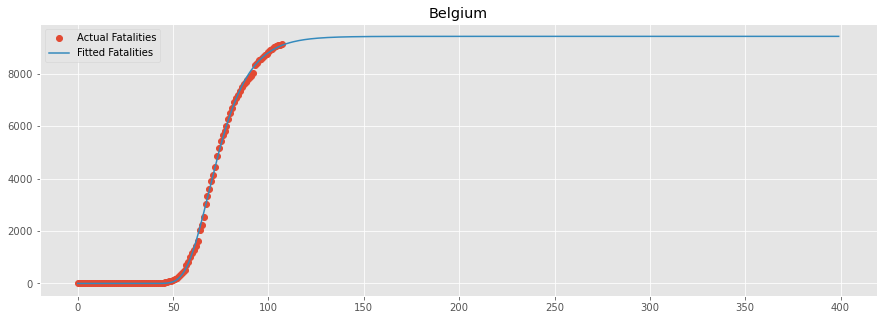

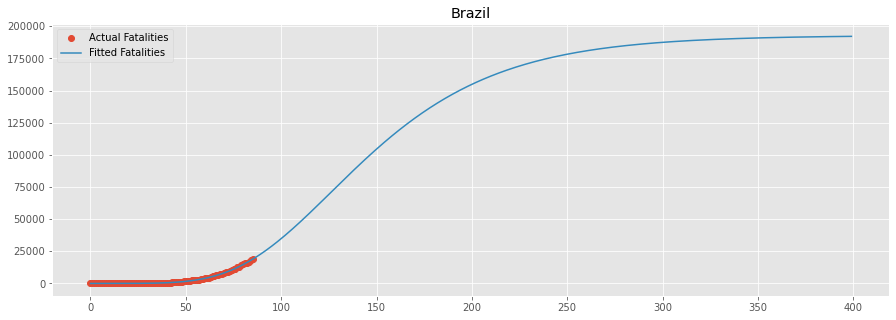

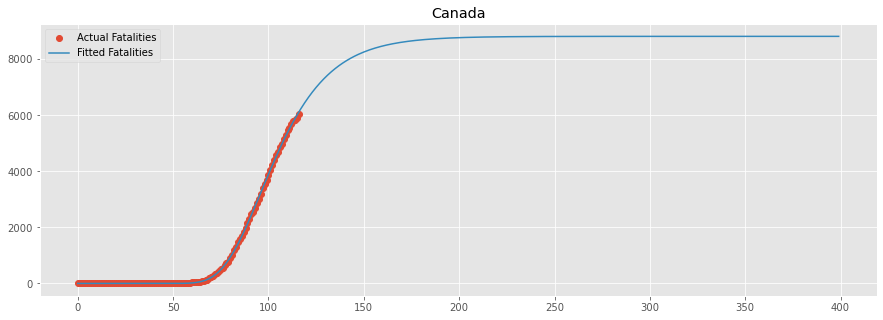

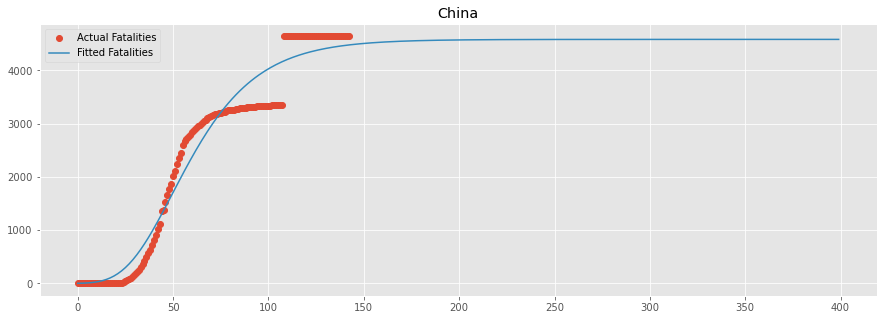

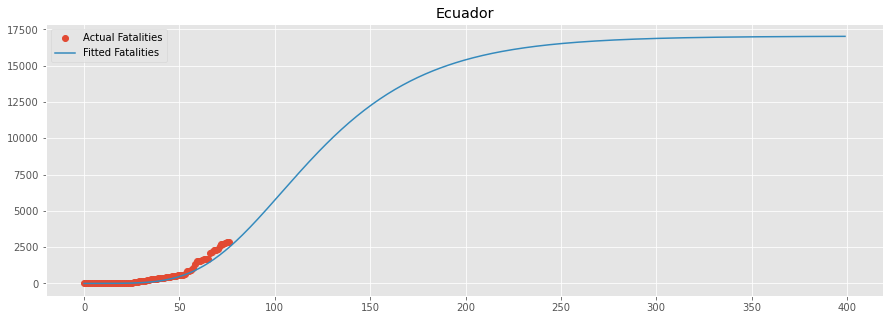

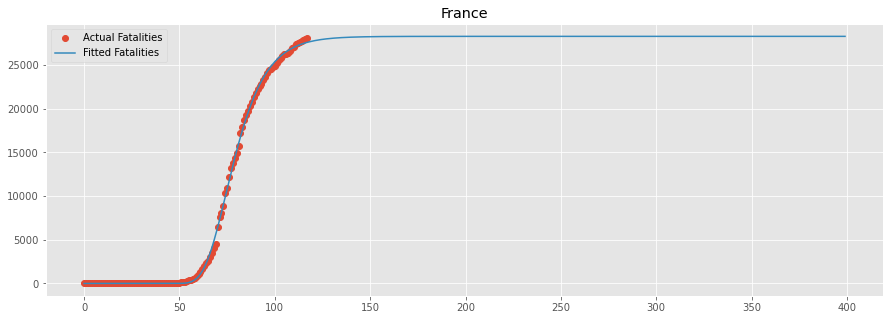

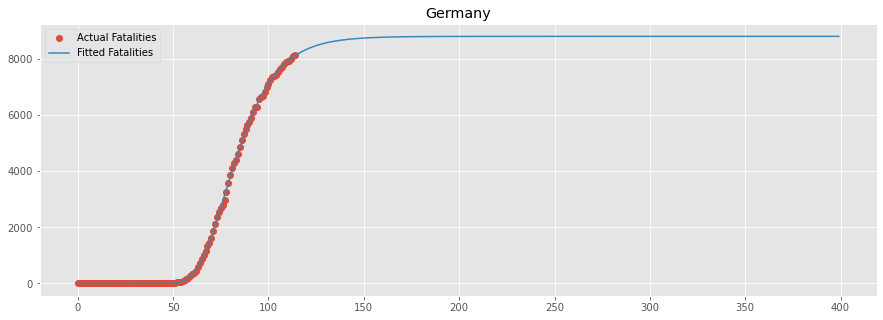

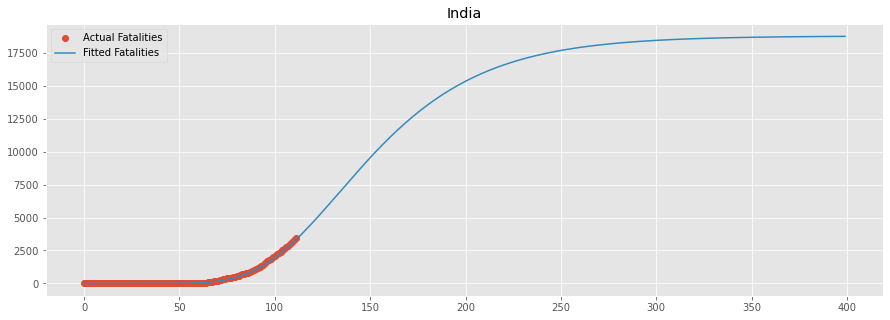

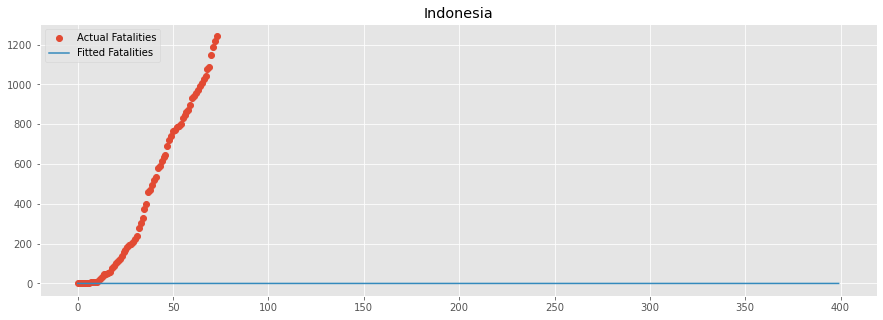

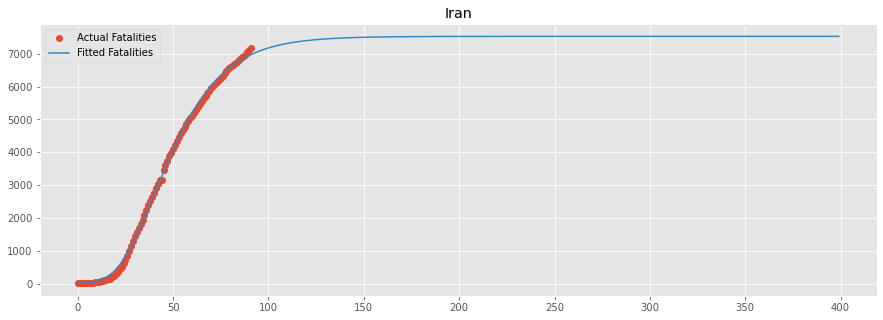

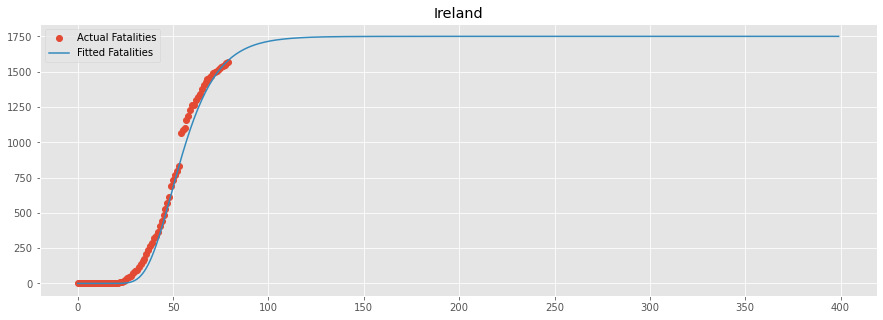

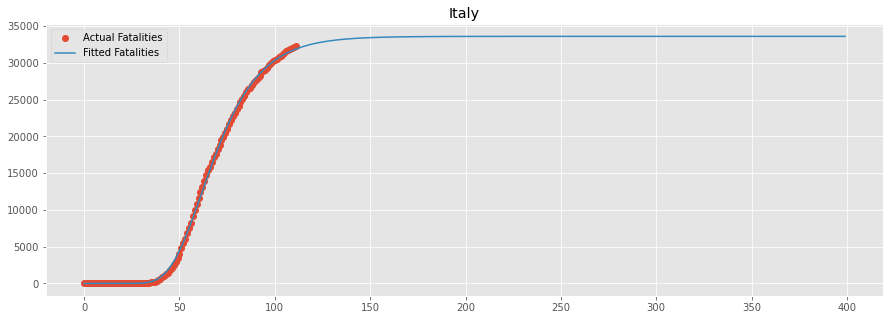

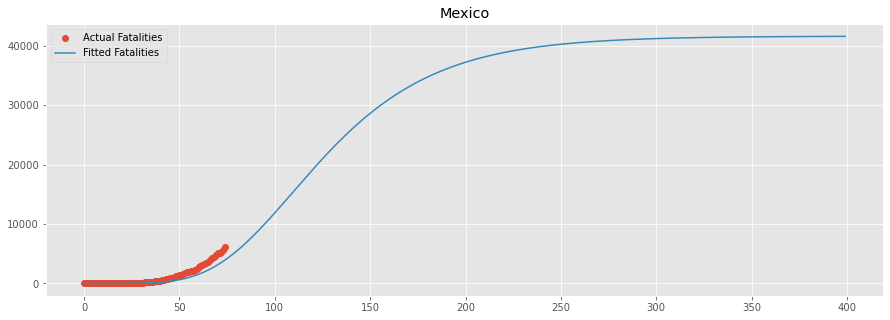

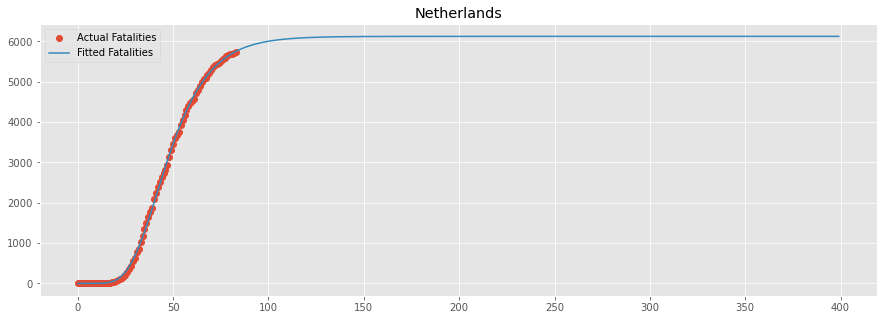

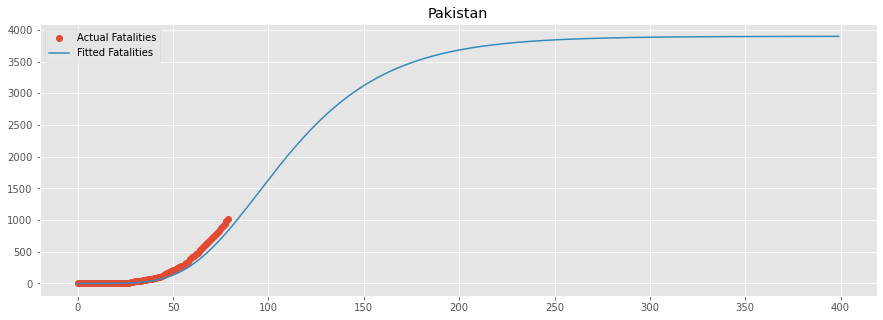

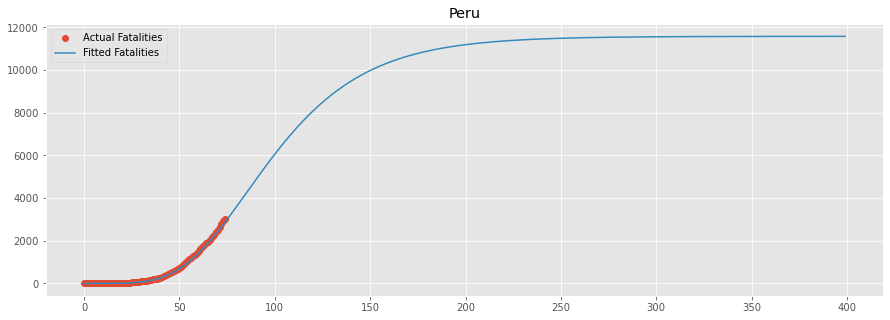

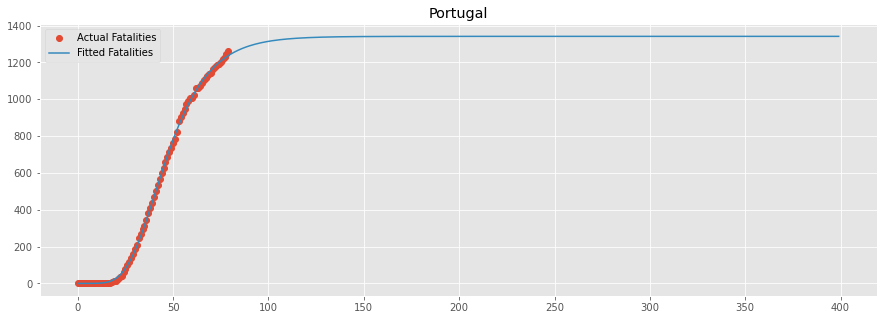

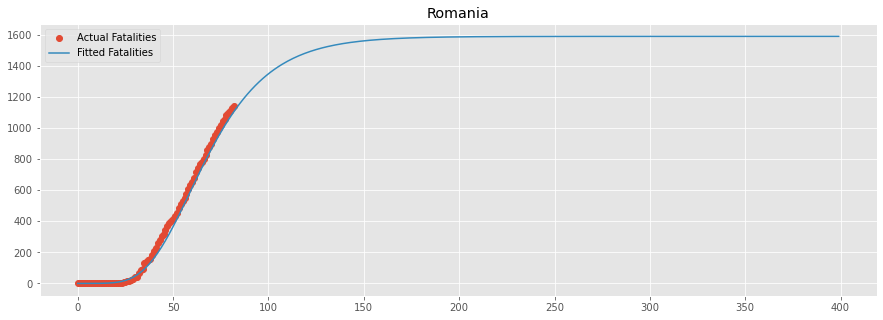

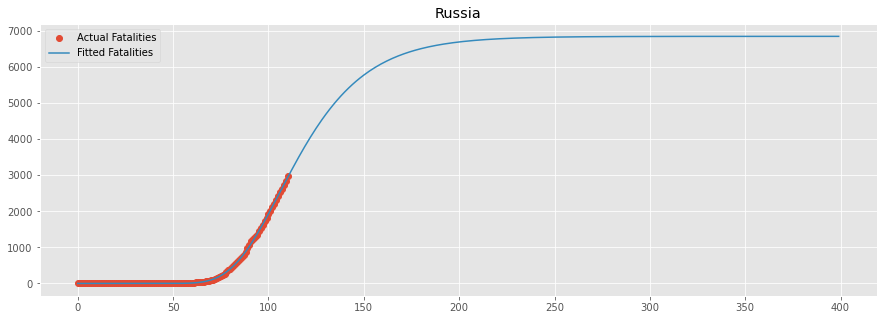

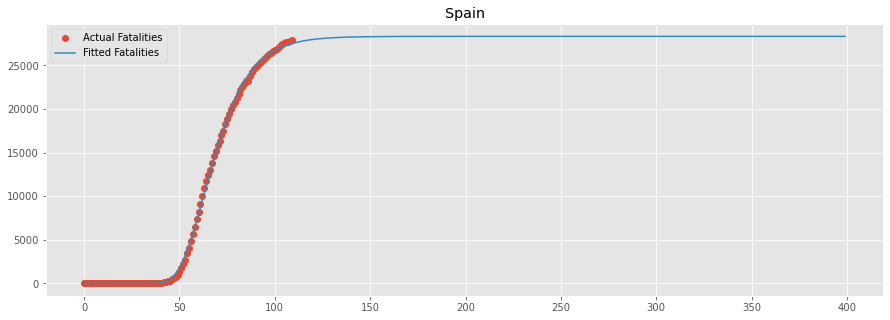

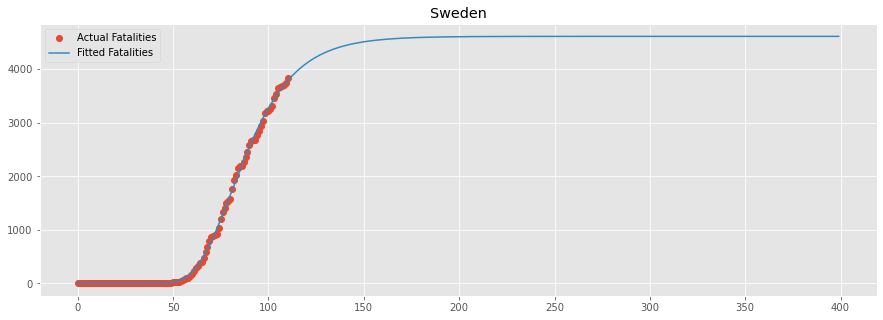

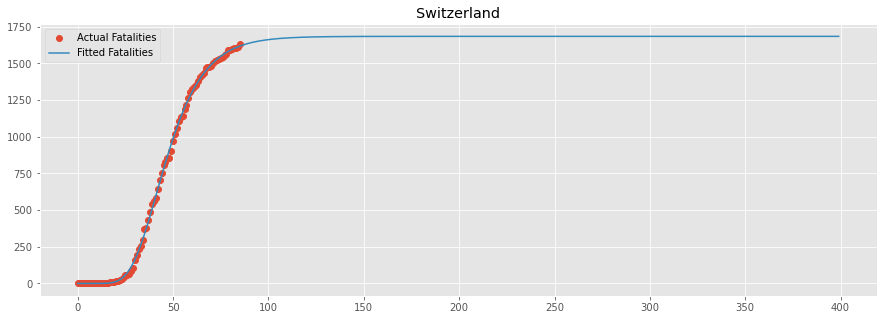

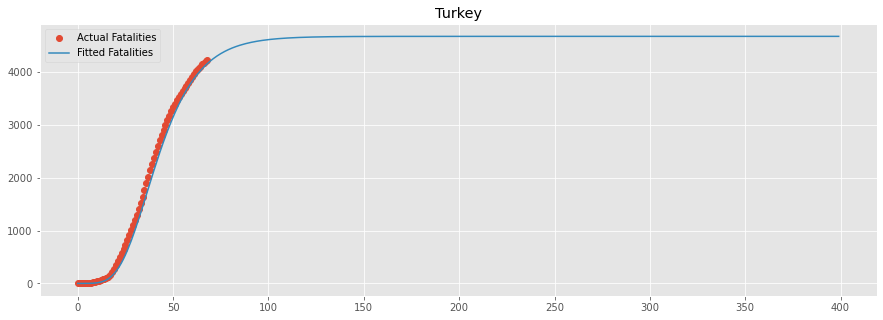

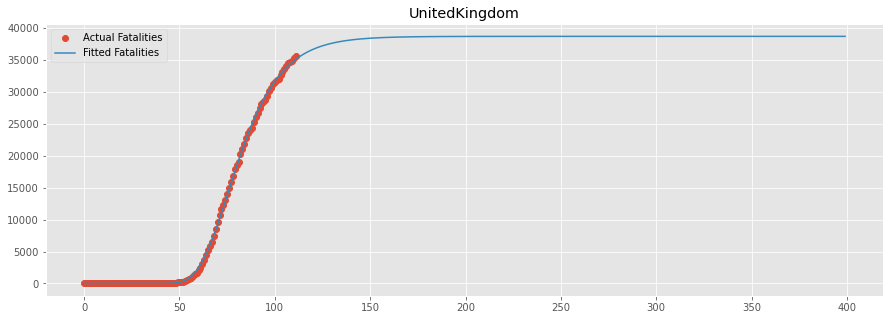

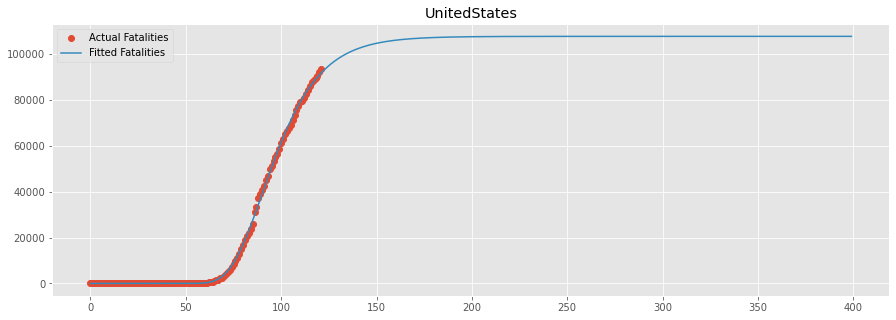

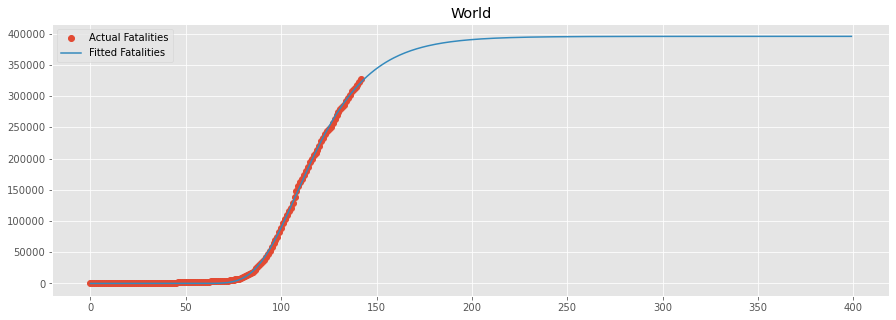

In [11]:
top_co = country_aggs[country_aggs['TotalFatalities'] >= 1000]['Country']

for co in top_co:    
    T = np.arange(0, 400, 1).tolist()
    country = co
    popt = list(df[df["Country"] == country]['total_deaths'])
    popt_ = list(log_regions[log_regions["Country"] == country]['est'])[0]

    yfit_ = []
    for x in T:
        fit = Gompertz(x, popt_[0],popt_[1],popt_[2])
        yfit_.append(fit)

    #print(yfit_)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(popt, label="Actual Fatalities",linestyle="",marker="o")
    ax.plot(T, yfit_, label="Fitted Fatalities")
    ax.title.set_text(country)
    plt.legend(loc="upper left")
plt.show()

In [12]:
#placeholder
df['total_deaths_forecast'] = 0
#df['row_number'] = df.groupby(['Country']).cumcount()
df.head(1)

,Country,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,total_deaths,new_deaths,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,population_size,hospital_beds_per_100k,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,area,Density_km,Inequality_spatial_transformed,C1_School.closing,C1_Flag,C2_Workplace.closing,C2_Flag,C3_Cancel.public.events,C3_Flag,C4_Restrictions.on.gatherings,C4_Flag,C5_Close.public.transport,C5_Flag,C6_Stay.at.home.requirements,C6_Flag,C7_Restrictions.on.internal.movement,C7_Flag,C8_International.travel.controls,E1_Income.support,E1_Flag,E2_Debt.contract.relief,E3_Fiscal.measures,E4_International.support,H1_Public.information.campaigns,H1_Flag,H2_Testing.policy,H3_Contact.tracing,H4_Emergency.investment.in.healthcare,H5_Investment.in.vaccines,M1_Wildcard,StringencyIndex,LegacyStringencyIndex,days_since_outbreak,days_since_deaths_crossed_0.1_per_million,days_since_10_deaths,gov_response_at_0.1_deaths_per_million,deaths_5_day_averages,infections_5_day_averages,peak_deaths_already_occurred_indicator,peak_cases_already_occurred_indicator,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,total_deaths_forecast
0,Afghanistan,2020-02-25,1,1,0.026,0.026,0,0,0.0,0.0,NaN,NaN,NaN,NaN,38928341.0,0.5,5.5,19.5,2181.532,8.970497,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,-34.0,-43.0,61.25,0.0,0.0052,1.0,0.0,4.804,8145,187,0


In [13]:
T = np.arange(0, 300, 1).tolist()

for index, region in df.iterrows():
    co = region['Country']
    #print(co)
    rdata = df[df['Country']==co]
    popt = list(rdata[rdata["Country"] == co]['total_deaths'])
    popt_ = list(log_regions[log_regions["Country"] == co]['est'])[0]

    yfit_ = []
    for x in T:
        fit = Gompertz(x, popt_[0],popt_[1],popt_[2])
        yfit_.append(fit)
    df['total_deaths_forecast'] = np.where(df['Country'] == co,max(yfit_),df['total_deaths_forecast'])

print("All done!")

All done!


In [14]:
df[df["Country"] == 'Italy'].head(2)

,Country,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,total_deaths,new_deaths,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,population_size,hospital_beds_per_100k,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,area,Density_km,Inequality_spatial_transformed,C1_School.closing,C1_Flag,C2_Workplace.closing,C2_Flag,C3_Cancel.public.events,C3_Flag,C4_Restrictions.on.gatherings,C4_Flag,C5_Close.public.transport,C5_Flag,C6_Stay.at.home.requirements,C6_Flag,C7_Restrictions.on.internal.movement,C7_Flag,C8_International.travel.controls,E1_Income.support,E1_Flag,E2_Debt.contract.relief,E3_Fiscal.measures,E4_International.support,H1_Public.information.campaigns,H1_Flag,H2_Testing.policy,H3_Contact.tracing,H4_Emergency.investment.in.healthcare,H5_Investment.in.vaccines,M1_Wildcard,StringencyIndex,LegacyStringencyIndex,days_since_outbreak,days_since_deaths_crossed_0.1_per_million,days_since_10_deaths,gov_response_at_0.1_deaths_per_million,deaths_5_day_averages,infections_5_day_averages,peak_deaths_already_occurred_indicator,peak_cases_already_occurred_indicator,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,total_deaths_forecast
3553,Italy,2020-01-31,3,3,0.05,0.05,0,0,0.0,0.0,NaN,NaN,NaN,NaN,60461828.0,3.18,19.9,46.5,41582.185,112.256818,2.999890e+11,198.447533,2.74423,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,3.0,0.0,NaN,0.0,0.0,0.0,2.0,1,1.0,2.0,0.0,0.0,NaN,19.44,22.86,0.0,-26.0,-26.0,64.44,0.0,0.01,1.0,1.0,534.718,227364,32330,33599.04524
3554,Italy,2020-02-01,3,0,0.05,0.00,0,0,0.0,0.0,NaN,NaN,NaN,NaN,60461828.0,3.18,19.9,46.5,41582.185,112.256818,2.999890e+11,198.447533,2.74423,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,3.0,0.0,NaN,0.0,0.0,0.0,2.0,1,1.0,2.0,0.0,0.0,NaN,19.44,22.86,1.0,-25.0,-25.0,64.44,0.0,0.01,1.0,1.0,534.718,227364,32330,33599.04524


Aggregate the data to the level of the country. Moreover, I am dropping countries with NA's, although I should probably look at imputing via regression at some point. This leaves us with 91 countries:

In [15]:
country_aggs = pd.DataFrame(df.groupby(['Country'],as_index=False).agg({'total_deaths_per_million':['max'],'total_cases':['max'],'total_deaths':['max'],'Obesity_rate':['max'],'Median_Age':['max'],'gdp_estimate_ppp':['max'],'age_adjusted_risk':['max'],'Inequality_spatial_transformed':['max'],'StringencyIndex':['max'],'gov_response_at_0.1_deaths_per_million':['max'],'days_since_outbreak':['max'],'area':['max'],'population_size':['max'],'total_deaths_forecast':['max'],'peak_deaths_already_occurred_indicator':['max']}))
country_aggs['CaseFatalityRate'] = country_aggs['total_deaths']/country_aggs['total_cases']
country_aggs.columns = ('Country','Total_deaths_per_million','TotalConfirmedCases','TotalFatalities','Obesity_rate','Median_Age','gdp_estimate_ppp','age_adjusted_risk','Inequality_spatial_transformed','StringencyIndex','gov_response_at_0.1_deaths_per_million','days_since_outbreak','area','population_size','total_deaths_forecast','peak_deaths_already_occurred_indicator','CaseFatalityRate')
country_aggs['intercept'] = 1
country_aggs = country_aggs.dropna()
#country_aggs = country_aggs[(country_aggs['TotalFatalities'] >= 50) & (country_aggs['peak_deaths_already_occurred_indicator'] == 1)]
country_aggs = country_aggs[country_aggs['peak_deaths_already_occurred_indicator'] == 1]
country_aggs.head(2)

,Country,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,Inequality_spatial_transformed,StringencyIndex,gov_response_at_0.1_deaths_per_million,days_since_outbreak,area,population_size,total_deaths_forecast,peak_deaths_already_occurred_indicator,CaseFatalityRate,intercept
1,Algeria,12.953,7542,568,27.4,28.9,16090.69,25.589402,18.046072,84.54,37.7,85.0,2.317000e+12,43851043.0,537.220767,1.0,0.075312,1
3,Argentina,8.917,9270,403,28.3,32.4,19970.52,47.082577,12.998710,100.00,100.0,78.0,2.780950e+12,45195777.0,720.780001,1.0,0.043474,1


In [16]:
country_aggs.describe(include = 'all')

,Country,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,Inequality_spatial_transformed,StringencyIndex,gov_response_at_0.1_deaths_per_million,days_since_outbreak,area,population_size,total_deaths_forecast,peak_deaths_already_occurred_indicator,CaseFatalityRate,intercept
count,49,49.000000,4.900000e+01,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,4.900000e+01,4.900000e+01,49.000000,49.0,49.000000,49.0
unique,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Niger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,101.029755,7.138965e+04,5792.979592,20.675510,34.655102,30607.914388,53.414800,6.823091,86.503469,62.732041,89.448980,1.028544e+12,5.271466e+07,11195.551091,1.0,0.059700,1.0
std,NaN,179.519373,2.274275e+05,15526.945248,8.723162,9.687278,20407.390389,35.738707,8.909340,9.708516,26.505187,18.559657,2.055590e+12,7.069438e+07,31386.069856,0.0,0.042455,0.0
min,NaN,0.802000,5.650000e+02,50.000000,4.300000,14.800000,1151.862000,7.005291,2.021756,53.300000,9.920000,61.000000,1.613944e+10,1.326539e+06,0.015002,1.0,0.005420,1.0
25%,NaN,6.143000,3.733000e+03,146.000000,17.900000,28.800000,14840.757000,20.510514,2.782624,80.290000,46.960000,77.000000,8.345676e+10,1.019671e+07,130.497065,1.0,0.034858,1.0
50%,NaN,25.418000,1.322100e+04,403.000000,21.600000,37.700000,29207.129000,47.082577,4.636666,88.090000,64.440000,83.000000,2.999890e+11,2.549988e+07,658.787009,1.0,0.047790,1.0
75%,NaN,70.283000,3.057500e+04,1263.000000,26.400000,43.300000,46827.354000,83.847406,6.760423,94.180000,83.600000,109.000000,9.983910e+11,6.046183e+07,4051.664400,1.0,0.064725,1.0


Add in cigarette data for possible use: --ruled out

In [17]:
#Cigarette consumption per year per person aged ≥ 15, 2016
#cig = pd.read_csv("/kaggle/input/cigaretteconsumption/cig.csv", sep='\t').reset_index()
#cig.columns = cig.columns.get_level_values(0)
#cig.columns =('Cig_Consumption_Rank','Country','Cigarette_consumption')
#cig['Country'] = cig['Country'].str.replace(" ","")
#cig.head()

Add in UV data: --ruled out

In [18]:
#UV = pd.read_csv("/kaggle/input/who-uvindex/UVIndex.csv")
#UV.columns = ("Country","UV_radiation")
#UV = UV.drop(UV.index[0])
#UV['Country'] = UV['Country'].str.replace(" ","")
#UV.head(10)

Add in disease data:

In [19]:
disease = pd.read_csv("/kaggle/input/disease-stats/diseaseLUP.CSV")
disease.columns = ("Country","Year","Meningitis","Lower_respiratory_infections","Protein_energy_malnutrition","Cardiovascular_diseases","Dementia","Kidney_disease","Respiratory_diseases","Liver_diseases","Digestive_diseases","Hepatitis","Cancers","Parkinson_disease","Fire","Drowning","Homicide","HIV_AIDS","Drug_use_disorders","Tuberculosis","Road_injuries","Maternal_disorders","Neonatal_disorders","Alcohol_use_disorders","Diarrheal_diseases","Hot_Cold_exposure","Nutritional_deficiencies","Suicide","Diabetes","Poisonings")
disease = disease.drop(disease.index[0])
disease['Country'] = disease['Country'].str.replace(" ","")
pd.set_option('display.max_columns', None)
disease.head(10)

,Country,Year,Meningitis,Lower_respiratory_infections,Protein_energy_malnutrition,Cardiovascular_diseases,Dementia,Kidney_disease,Respiratory_diseases,Liver_diseases,Digestive_diseases,Hepatitis,Cancers,Parkinson_disease,Fire,Drowning,Homicide,HIV_AIDS,Drug_use_disorders,Tuberculosis,Road_injuries,Maternal_disorders,Neonatal_disorders,Alcohol_use_disorders,Diarrheal_diseases,Hot_Cold_exposure,Nutritional_deficiencies,Suicide,Diabetes,Poisonings
1,Albania,2017,18.606850,381.653138,3.257634,12144.970440,1337.440187,362.537159,736.029291,308.797730,489.495931,2.959034,4344.972580,233.618829,16.797344,37.618618,68.846538,1.285800,22.988953,11.986996,247.535292,3.475719,183.685063,15.465368,6.939839,10.528083,4.458938,161.977426,135.001529,11.384000
2,Algeria,2017,379.614524,4723.762257,80.517066,79389.073240,8175.242117,4577.022553,5508.419832,2935.124513,4800.227615,312.704332,21656.083090,1139.958076,735.957263,509.292514,438.667163,326.660742,1010.678862,417.069297,6905.410229,630.191116,6511.279864,130.332484,377.244709,50.093911,97.704089,1698.665146,5201.535330,366.645603
3,AmericanSamoa,2017,0.731541,13.799033,1.468605,99.849458,8.453716,23.521397,16.875169,5.888123,11.914010,0.064914,58.821252,1.368234,0.513867,3.805962,2.901452,0.335763,0.426503,0.376901,4.278351,1.208337,4.608330,0.344536,1.180293,1.142969,1.572362,3.481451,33.245378,0.407851
4,AndeanLatinAmerica,2017,581.273232,27147.025550,1759.381212,62674.082580,17816.042070,14191.067730,14000.979550,11233.887040,19460.262290,190.331576,56805.521450,2480.247523,779.653039,1920.404654,4187.259032,4655.939469,747.729460,3884.471767,11169.392570,1252.663317,8474.229397,1015.506167,2145.728973,274.305127,1994.021903,3263.203985,11590.868730,419.109363
5,Andorra,2017,0.256891,30.980068,0.135491,171.440664,56.321114,5.788669,32.681219,10.080082,27.441577,0.117097,171.709417,6.788084,0.778312,0.440135,0.561617,0.441990,2.138703,0.357184,3.734440,0.031863,0.436309,1.870977,1.097464,0.377335,0.205362,8.186095,5.269972,0.207766
6,Angola,2017,3231.569615,14508.404990,4432.241559,21784.661830,1649.393457,2809.242811,3750.627243,5294.233192,8274.165559,411.516415,12039.834280,240.171415,711.483354,2005.294815,889.743278,14584.702430,167.073060,11409.417530,6781.226022,2126.952851,17881.913650,246.994958,17390.300880,141.461057,4515.796896,1745.994646,3558.147037,285.432396
7,AntiguaandBarbuda,2017,0.949083,32.543829,2.232637,186.777206,26.920698,25.988410,11.783725,11.169694,20.664035,0.191596,119.539032,4.747351,1.794246,4.397954,4.753644,7.509007,0.912520,0.367873,6.686315,0.640171,5.107090,6.573077,1.403231,0.459664,2.298385,2.625975,45.482503,0.446067
8,Argentina,2017,494.948379,31058.142250,983.607619,105776.740500,18616.816490,10834.300190,18992.483860,7346.319944,14905.837910,178.405093,74065.896660,2917.513863,756.370034,709.834602,2733.485868,1719.217843,797.912049,679.348497,6457.318523,378.840519,3600.109017,857.090286,651.446992,101.200180,1075.354199,5024.770844,9345.109432,357.743936
9,Armenia,2017,8.618483,500.864067,1.268510,13631.149860,1357.246658,429.616729,1310.628476,1107.319912,1719.854038,5.791550,5755.616259,179.975115,36.886793,47.955186,111.740893,23.728822,41.992405,76.604700,241.867640,9.133619,140.951657,58.152770,13.210363,45.743905,3.530430,301.683658,1142.020098,20.885077
10,Australasia,2017,70.983721,5179.115729,102.226064,62998.475070,20093.751640,5228.033578,12965.239670,2478.890897,7111.393406,111.295432,60092.136560,2705.161694,184.768443,269.064431,387.030288,86.559359,1297.190612,106.646910,2022.817330,21.160442,660.670613,669.767456,258.261347,77.156387,131.510621,3592.279876,4310.651641,62.272136


Create merge function using fuzzy match:

In [20]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

Match the two:

In [21]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [22]:
#fuzzy_merge(country_aggs, UV, 'Country', 'Country', threshold=80)
#UV.columns = ("matches","UV_radiation")
#country_aggs_ = pd.merge(country_aggs, UV, on='matches', how='inner')
#country_aggs_.head(2)
#country_aggs_ = country_aggs_.dropna()
#del country_aggs_['matches']
#country_aggs_.head(2)

In [23]:
#fuzzy_merge(country_aggs_, cig, 'Country', 'Country', threshold=80)
#cig.columns = ('Cig_Consumption_Rank','matches','Cigarette_consumption')
#country_aggs_ = pd.merge(country_aggs_, cig, on='matches', how='inner')
#country_aggs_ = country_aggs_.dropna()
#country_aggs_.head(2)

In [24]:
#country_aggs_ = country_aggs_.dropna()
#del country_aggs_['matches']
#country_aggs_.head(2)

In [25]:
fuzzy_merge(country_aggs, disease, 'Country', 'Country', threshold=80)
disease.columns = ("matches","Year","Meningitis","Lower_respiratory_infections","Protein_energy_malnutrition","Cardiovascular_diseases","Dementia","Kidney_disease","Respiratory_diseases","Liver_diseases","Digestive_diseases","Hepatitis","Cancers","Parkinson_disease","Fire","Drowning","Homicide","HIV_AIDS","Drug_use_disorders","Tuberculosis","Road_injuries","Maternal_disorders","Neonatal_disorders","Alcohol_use_disorders","Diarrheal_diseases","Hot_Cold_exposure","Nutritional_deficiencies","Suicide","Diabetes","Poisonings")
country_aggs_ = pd.merge(country_aggs, disease, on='matches', how='inner')
country_aggs_ = country_aggs_.dropna()
country_aggs_.head(20)

,Country,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,Inequality_spatial_transformed,StringencyIndex,gov_response_at_0.1_deaths_per_million,days_since_outbreak,area,population_size,total_deaths_forecast,peak_deaths_already_occurred_indicator,CaseFatalityRate,intercept,matches,Year,Meningitis,Lower_respiratory_infections,Protein_energy_malnutrition,Cardiovascular_diseases,Dementia,Kidney_disease,Respiratory_diseases,Liver_diseases,Digestive_diseases,Hepatitis,Cancers,Parkinson_disease,Fire,Drowning,Homicide,HIV_AIDS,Drug_use_disorders,Tuberculosis,Road_injuries,Maternal_disorders,Neonatal_disorders,Alcohol_use_disorders,Diarrheal_diseases,Hot_Cold_exposure,Nutritional_deficiencies,Suicide,Diabetes,Poisonings
0,Algeria,12.953,7542,568,27.4,28.9,16090.690,25.589402,18.046072,84.54,37.70,85.0,2.317000e+12,43851043.0,537.220767,1.0,0.075312,1,Algeria,2017,379.614524,4723.762257,80.517066,79389.073240,8175.242117,4577.022553,5508.419832,2935.124513,4800.227615,312.704332,21656.083090,1139.958076,735.957263,509.292514,438.667163,326.660742,1010.678862,417.069297,6905.410229,630.191116,6511.279864,130.332484,377.244709,50.093911,97.704089,1698.665146,5201.535330,366.645603
1,Argentina,8.917,9270,403,28.3,32.4,19970.520,47.082577,12.998710,100.00,100.00,78.0,2.780950e+12,45195777.0,720.780001,1.0,0.043474,1,Argentina,2017,494.948379,31058.142250,983.607619,105776.740500,18616.816490,10834.300190,18992.483860,7346.319944,14905.837910,178.405093,74065.896660,2917.513863,756.370034,709.834602,2733.485868,1719.217843,797.912049,679.348497,6457.318523,378.840519,3600.109017,857.090286,651.446992,101.200180,1075.354199,5024.770844,9345.109432,357.743936
2,Australia,3.922,7079,100,29.0,37.5,54799.038,70.185129,59.591826,71.44,19.44,117.0,7.686850e+12,25499881.0,105.095763,1.0,0.014126,1,Australia,2017,56.798487,4451.177815,95.205463,52100.555210,17118.892650,4455.439414,10821.960960,2186.752210,6111.539373,108.051668,50254.075350,2328.239022,162.143976,215.472456,327.400513,76.579921,1222.502214,88.659335,1660.799760,14.764224,540.120149,604.112343,187.523686,69.134297,121.434716,3055.189141,3755.066653,53.208070
3,Austria,70.283,16275,633,20.1,44.5,55171.987,88.306195,2.950528,84.79,57.27,85.0,8.345676e+10,9006400.0,658.787009,1.0,0.038894,1,Austria,2017,32.332976,961.065935,1.506607,31386.139930,7480.678900,2753.507453,3383.093447,1860.129117,3227.180637,5.640053,21744.672200,994.229958,87.658978,66.081628,68.683943,37.968914,178.389123,51.259390,481.316929,3.707087,127.984540,489.410108,98.117541,62.690048,8.687968,1422.042336,2059.225130,31.759665
4,Belgium,789.500,55983,9150,22.1,41.6,50904.687,89.592592,2.467817,83.60,21.03,107.0,3.052465e+10,11589616.0,9428.696500,1.0,0.163442,1,Belgium,2017,47.621603,5669.182269,207.441890,32194.216420,10550.332120,2096.754168,6804.251844,2004.398686,5111.162188,38.936199,30781.958430,1228.373604,181.538586,93.131471,151.596320,61.885558,275.725847,90.165913,1035.352648,7.995617,180.275014,515.660038,697.427858,86.221383,269.552799,2131.892838,1436.396061,42.903944
5,Bolivia,17.048,4919,199,20.2,25.3,8524.755,31.121585,9.453314,97.35,94.58,70.0,1.086520e+12,11673029.0,16856.360765,1.0,0.040455,1,Bolivia,2017,167.999841,5359.620645,568.798867,15274.840680,2650.846513,3165.190656,3121.972766,2215.414757,4077.542619,55.155163,12195.403410,478.117317,185.365091,429.248300,684.640155,1167.193614,148.363906,1145.357809,2127.874011,463.729060,2825.608483,304.344631,555.978135,67.834900,641.493279,668.248542,2902.739936,94.197955
6,BosniaandHerzegovina,41.148,2334,135,17.9,43.3,14894.162,65.945436,2.503205,91.40,87.71,76.0,5.152733e+10,3280815.0,0.015002,1.0,0.057841,1,BosniaandHerzegovina,2017,11.738016,359.594792,2.029116,18107.318690,1990.592139,604.361436,1310.164147,577.392799,1135.887604,6.565942,8950.336060,324.063116,40.811037,35.318084,82.787545,1.535890,28.556721,134.652918,268.622125,1.972577,87.249351,112.523667,8.647880,3.

In [26]:
country_aggs_.head(20)

,Country,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,Inequality_spatial_transformed,StringencyIndex,gov_response_at_0.1_deaths_per_million,days_since_outbreak,area,population_size,total_deaths_forecast,peak_deaths_already_occurred_indicator,CaseFatalityRate,intercept,matches,Year,Meningitis,Lower_respiratory_infections,Protein_energy_malnutrition,Cardiovascular_diseases,Dementia,Kidney_disease,Respiratory_diseases,Liver_diseases,Digestive_diseases,Hepatitis,Cancers,Parkinson_disease,Fire,Drowning,Homicide,HIV_AIDS,Drug_use_disorders,Tuberculosis,Road_injuries,Maternal_disorders,Neonatal_disorders,Alcohol_use_disorders,Diarrheal_diseases,Hot_Cold_exposure,Nutritional_deficiencies,Suicide,Diabetes,Poisonings
0,Algeria,12.953,7542,568,27.4,28.9,16090.690,25.589402,18.046072,84.54,37.70,85.0,2.317000e+12,43851043.0,537.220767,1.0,0.075312,1,Algeria,2017,379.614524,4723.762257,80.517066,79389.073240,8175.242117,4577.022553,5508.419832,2935.124513,4800.227615,312.704332,21656.083090,1139.958076,735.957263,509.292514,438.667163,326.660742,1010.678862,417.069297,6905.410229,630.191116,6511.279864,130.332484,377.244709,50.093911,97.704089,1698.665146,5201.535330,366.645603
1,Argentina,8.917,9270,403,28.3,32.4,19970.520,47.082577,12.998710,100.00,100.00,78.0,2.780950e+12,45195777.0,720.780001,1.0,0.043474,1,Argentina,2017,494.948379,31058.142250,983.607619,105776.740500,18616.816490,10834.300190,18992.483860,7346.319944,14905.837910,178.405093,74065.896660,2917.513863,756.370034,709.834602,2733.485868,1719.217843,797.912049,679.348497,6457.318523,378.840519,3600.109017,857.090286,651.446992,101.200180,1075.354199,5024.770844,9345.109432,357.743936
2,Australia,3.922,7079,100,29.0,37.5,54799.038,70.185129,59.591826,71.44,19.44,117.0,7.686850e+12,25499881.0,105.095763,1.0,0.014126,1,Australia,2017,56.798487,4451.177815,95.205463,52100.555210,17118.892650,4455.439414,10821.960960,2186.752210,6111.539373,108.051668,50254.075350,2328.239022,162.143976,215.472456,327.400513,76.579921,1222.502214,88.659335,1660.799760,14.764224,540.120149,604.112343,187.523686,69.134297,121.434716,3055.189141,3755.066653,53.208070
3,Austria,70.283,16275,633,20.1,44.5,55171.987,88.306195,2.950528,84.79,57.27,85.0,8.345676e+10,9006400.0,658.787009,1.0,0.038894,1,Austria,2017,32.332976,961.065935,1.506607,31386.139930,7480.678900,2753.507453,3383.093447,1860.129117,3227.180637,5.640053,21744.672200,994.229958,87.658978,66.081628,68.683943,37.968914,178.389123,51.259390,481.316929,3.707087,127.984540,489.410108,98.117541,62.690048,8.687968,1422.042336,2059.225130,31.759665
4,Belgium,789.500,55983,9150,22.1,41.6,50904.687,89.592592,2.467817,83.60,21.03,107.0,3.052465e+10,11589616.0,9428.696500,1.0,0.163442,1,Belgium,2017,47.621603,5669.182269,207.441890,32194.216420,10550.332120,2096.754168,6804.251844,2004.398686,5111.162188,38.936199,30781.958430,1228.373604,181.538586,93.131471,151.596320,61.885558,275.725847,90.165913,1035.352648,7.995617,180.275014,515.660038,697.427858,86.221383,269.552799,2131.892838,1436.396061,42.903944
5,Bolivia,17.048,4919,199,20.2,25.3,8524.755,31.121585,9.453314,97.35,94.58,70.0,1.086520e+12,11673029.0,16856.360765,1.0,0.040455,1,Bolivia,2017,167.999841,5359.620645,568.798867,15274.840680,2650.846513,3165.190656,3121.972766,2215.414757,4077.542619,55.155163,12195.403410,478.117317,185.365091,429.248300,684.640155,1167.193614,148.363906,1145.357809,2127.874011,463.729060,2825.608483,304.344631,555.978135,67.834900,641.493279,668.248542,2902.739936,94.197955
6,BosniaandHerzegovina,41.148,2334,135,17.9,43.3,14894.162,65.945436,2.503205,91.40,87.71,76.0,5.152733e+10,3280815.0,0.015002,1.0,0.057841,1,BosniaandHerzegovina,2017,11.738016,359.594792,2.029116,18107.318690,1990.592139,604.361436,1310.164147,577.392799,1135.887604,6.565942,8950.336060,324.063116,40.811037,35.318084,82.787545,1.535890,28.556721,134.652918,268.622125,1.972577,87.249351,112.523667,8.647880,3.

In [27]:
country_aggs_['Density_overall'] = (np.power((country_aggs_['population_size'])/(country_aggs_['area']),0.15))
country_aggs_['PopulationFatality'] = country_aggs_['TotalFatalities']/country_aggs_['population_size']
country_aggs_['Total_deaths_per_million_forecast'] = country_aggs_['total_deaths_forecast']/(country_aggs_['population_size']/1000000.0)

Observe number of countries we are left with:

In [28]:
display(country_aggs_.shape)
sum(country_aggs_['peak_deaths_already_occurred_indicator'])

(49, 51)

49.0

# Distribution and correlation plots
Observe distribution of designated response variable:

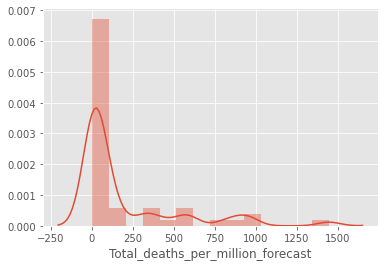

In [29]:
sns.distplot(country_aggs_['Total_deaths_per_million_forecast'])
plt.show()

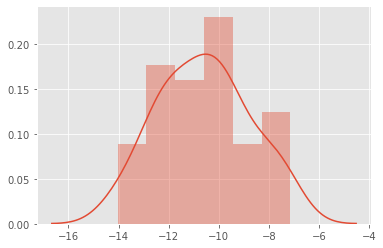

In [30]:
sns.distplot(np.log(country_aggs_['TotalFatalities']/country_aggs_['population_size']));

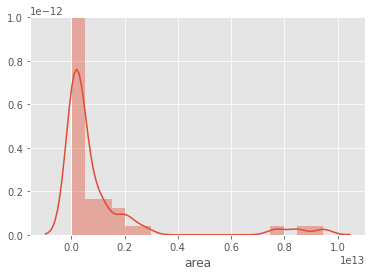

In [31]:
sns.distplot((country_aggs_['area']));

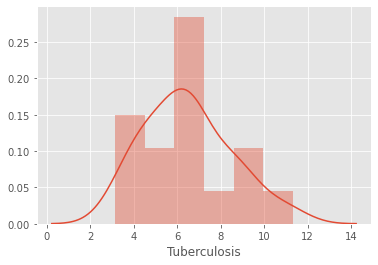

In [32]:
sns.distplot(np.log(country_aggs_['Tuberculosis']));
country_aggs_['Tuberculosis_log'] = np.log(country_aggs_['Tuberculosis'])

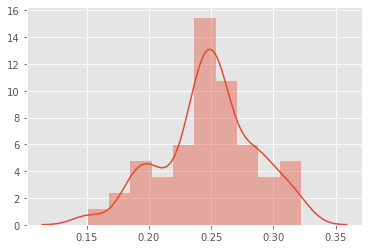

In [33]:
sns.distplot((np.power((country_aggs_['population_size'])/(country_aggs_['area']),0.15)));

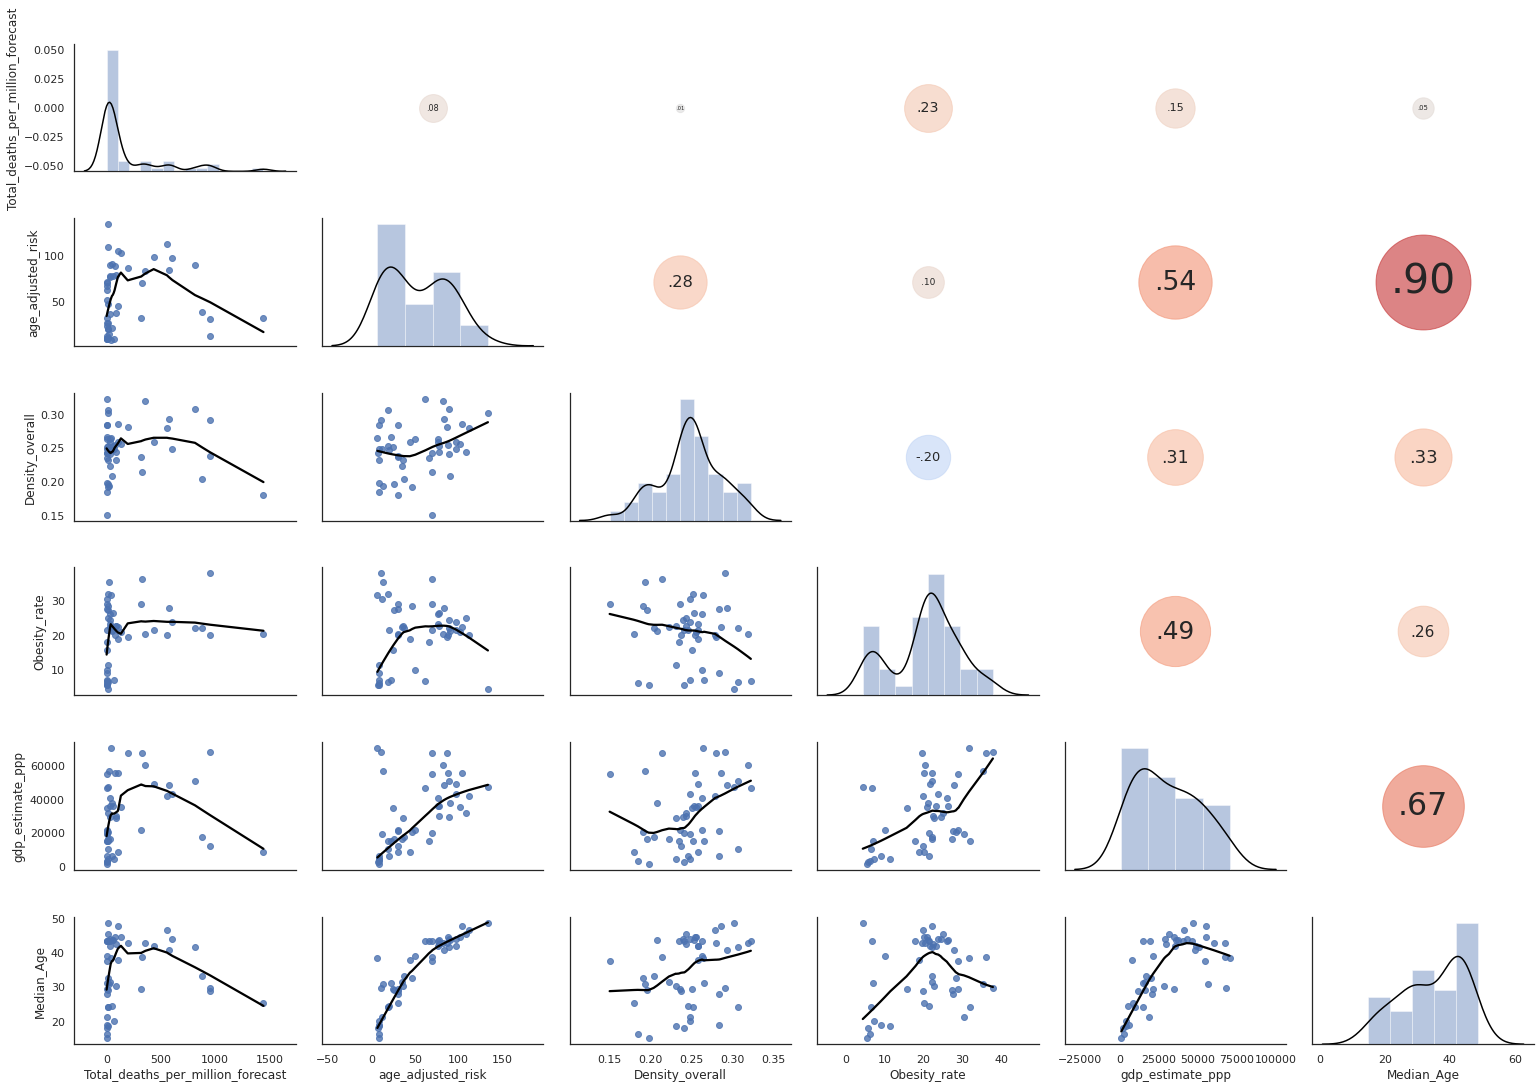

In [34]:

# dataset = country_aggs_[['PopulationFatality','age_adjusted_risk','Density_overall','Obesity_rate','gdp_estimate_ppp','Median_Age','Inequality_spatial_transformed','StringencyIndex','gov_response_at_0.1_deaths_per_million','days_since_outbreak']]
dataset = country_aggs_[['Total_deaths_per_million_forecast','age_adjusted_risk','Density_overall','Obesity_rate','gdp_estimate_ppp','Median_Age']]


def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

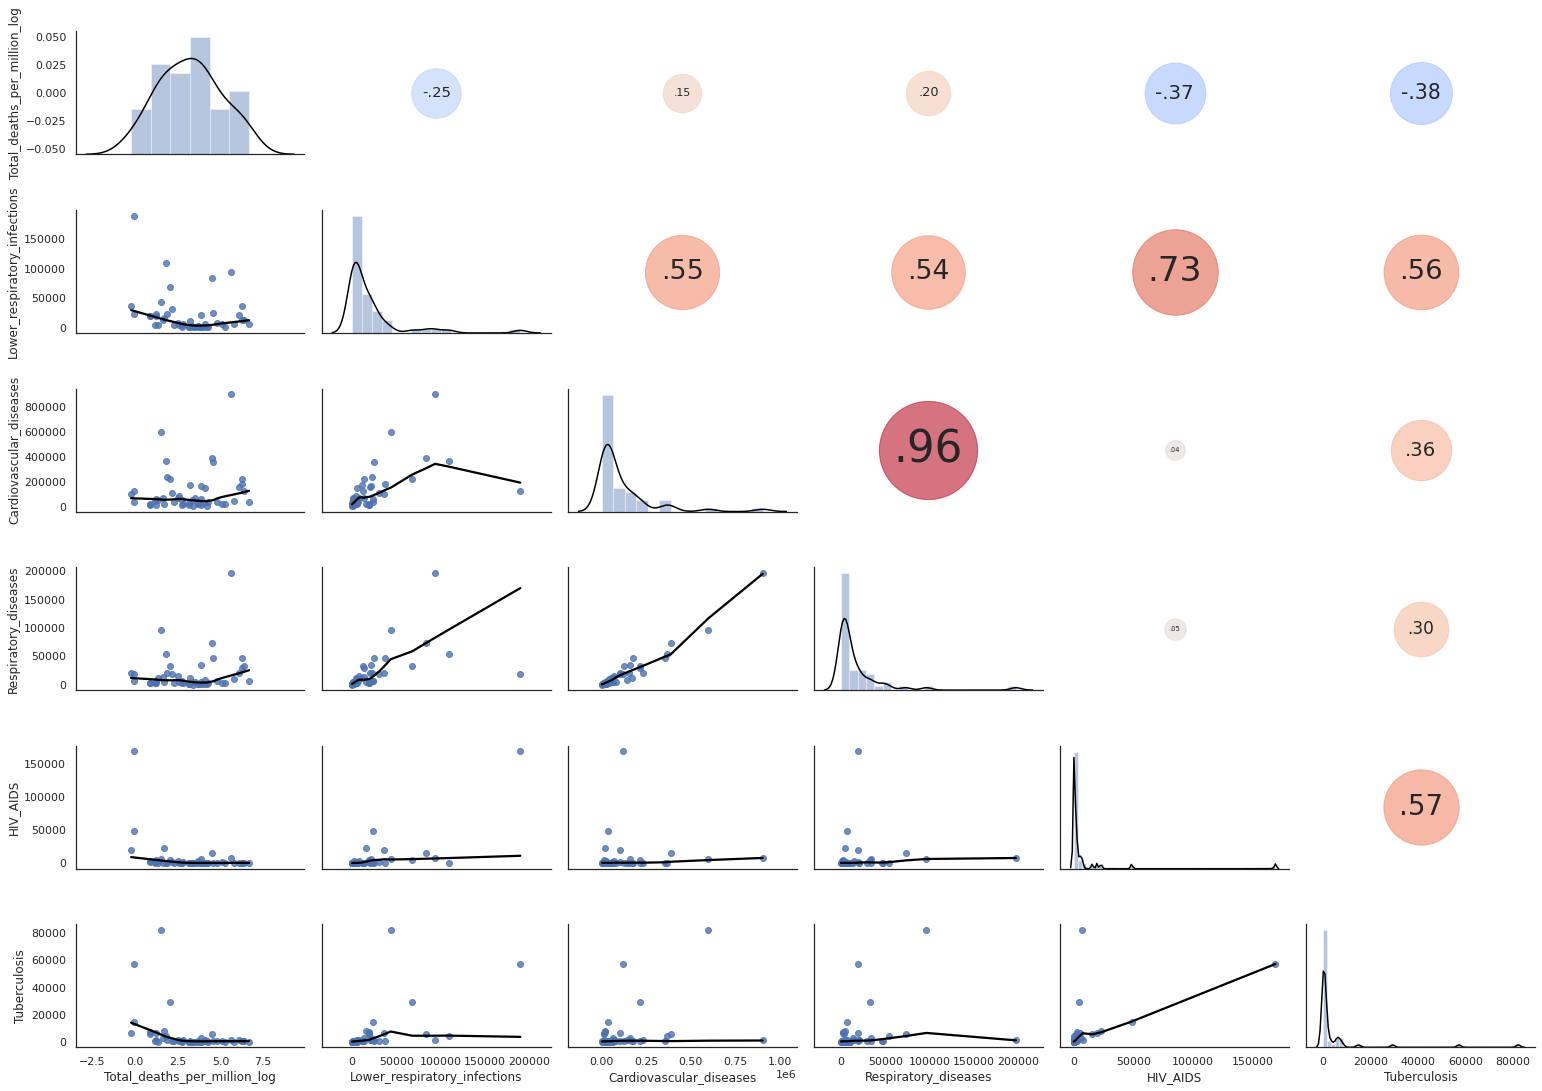

In [35]:
#dataset = country_aggs_[['Total_deaths_per_million_forecast',"Lower_respiratory_infections","Protein_energy_malnutrition","Cardiovascular_diseases","Respiratory_diseases","HIV_AIDS","Tuberculosis","Diabetes"]]
country_aggs_['Total_deaths_per_million_forecast_log'] = np.log(country_aggs_['total_deaths_forecast']/country_aggs_['population_size'])
country_aggs_['Total_deaths_per_million_log'] = np.log(country_aggs_['Total_deaths_per_million'])
dataset = country_aggs_[['Total_deaths_per_million_log',"Lower_respiratory_infections","Cardiovascular_diseases","Respiratory_diseases","HIV_AIDS","Tuberculosis"]]
sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

The above plot shows that disease prevalence in a country can account for some of the variance in the response variable. Let's try another approach to attempt to get better predictive ability out of the data. Let's create ranks for each of them and then test a combined rank:

In [36]:
disease.head()

,matches,Year,Meningitis,Lower_respiratory_infections,Protein_energy_malnutrition,Cardiovascular_diseases,Dementia,Kidney_disease,Respiratory_diseases,Liver_diseases,Digestive_diseases,Hepatitis,Cancers,Parkinson_disease,Fire,Drowning,Homicide,HIV_AIDS,Drug_use_disorders,Tuberculosis,Road_injuries,Maternal_disorders,Neonatal_disorders,Alcohol_use_disorders,Diarrheal_diseases,Hot_Cold_exposure,Nutritional_deficiencies,Suicide,Diabetes,Poisonings
1,Albania,2017,18.606850,381.653138,3.257634,12144.970440,1337.440187,362.537159,736.029291,308.797730,489.495931,2.959034,4344.972580,233.618829,16.797344,37.618618,68.846538,1.285800,22.988953,11.986996,247.535292,3.475719,183.685063,15.465368,6.939839,10.528083,4.458938,161.977426,135.001529,11.384000
2,Algeria,2017,379.614524,4723.762257,80.517066,79389.073240,8175.242117,4577.022553,5508.419832,2935.124513,4800.227615,312.704332,21656.083090,1139.958076,735.957263,509.292514,438.667163,326.660742,1010.678862,417.069297,6905.410229,630.191116,6511.279864,130.332484,377.244709,50.093911,97.704089,1698.665146,5201.535330,366.645603
3,AmericanSamoa,2017,0.731541,13.799033,1.468605,99.849458,8.453716,23.521397,16.875169,5.888123,11.914010,0.064914,58.821252,1.368234,0.513867,3.805962,2.901452,0.335763,0.426503,0.376901,4.278351,1.208337,4.608330,0.344536,1.180293,1.142969,1.572362,3.481451,33.245378,0.407851
4,AndeanLatinAmerica,2017,581.273232,27147.025550,1759.381212,62674.082580,17816.042070,14191.067730,14000.979550,11233.887040,19460.262290,190.331576,56805.521450,2480.247523,779.653039,1920.404654,4187.259032,4655.939469,747.729460,3884.471767,11169.392570,1252.663317,8474.229397,1015.506167,2145.728973,274.305127,1994.021903,3263.203985,11590.868730,419.109363
5,Andorra,2017,0.256891,30.980068,0.135491,171.440664,56.321114,5.788669,32.681219,10.080082,27.441577,0.117097,171.709417,6.788084,0.778312,0.440135,0.561617,0.441990,2.138703,0.357184,3.734440,0.031863,0.436309,1.870977,1.097464,0.377335,0.205362,8.186095,5.269972,0.207766


In [37]:
country_aggs_['Tuberculosis_Rank'] = country_aggs_['Tuberculosis'].rank()
country_aggs_["Lower_respiratory_infections_Rank"] = country_aggs_['Lower_respiratory_infections'].rank()
country_aggs_["Cardiovascular_diseases_Rank"] = country_aggs_['Cardiovascular_diseases'].rank()
country_aggs_["Respiratory_diseases_Rank"] = country_aggs_['Respiratory_diseases'].rank()
country_aggs_["HIV_AIDS_Rank"] = country_aggs_['HIV_AIDS'].rank()
country_aggs_["Hepatitis_Rank"] = country_aggs_['Hepatitis'].rank()
country_aggs_["Diarrheal_diseases_Rank"] = country_aggs_['Diarrheal_diseases'].rank()
##
country_aggs_['Hygiene_Rank_'] = country_aggs_[['Hepatitis_Rank','Tuberculosis_Rank','Diarrheal_diseases_Rank','HIV_AIDS_Rank']].mean(axis=1)
country_aggs_['Dread_Disease_Rank'] = country_aggs_[['Lower_respiratory_infections_Rank','Cardiovascular_diseases_Rank','Respiratory_diseases_Rank','HIV_AIDS_Rank']].mean(axis=1)
#Dec
country_aggs_["Lower_respiratory_infections_Dec"] = pd.qcut(country_aggs_['Lower_respiratory_infections'], 10, labels=False)
country_aggs_["Total_deaths_per_million_Dec"] = pd.qcut(country_aggs_['Total_deaths_per_million'], 10, labels=False)
#Hygiene
country_aggs_['Tuberculosis_Dec'] = pd.qcut(country_aggs_['Tuberculosis'], 10, labels=False)
country_aggs_["HIV_AIDS_Dec"] = pd.qcut(country_aggs_['HIV_AIDS'], 10, labels=False)
country_aggs_["Hepatitis_Dec"] = pd.qcut(country_aggs_['Hepatitis'], 10, labels=False)
country_aggs_["Diarrheal_diseases_Dec"] = pd.qcut(country_aggs_['Diarrheal_diseases'], 10, labels=False)
#Comorbid
country_aggs_["Cardiovascular_diseases_Dec"] = pd.qcut(country_aggs_['Cardiovascular_diseases'], 10, labels=False)
country_aggs_["Respiratory_diseases_Dec"] = pd.qcut(country_aggs_['Respiratory_diseases'], 10, labels=False)
country_aggs_["Kidney_disease_Dec"] = pd.qcut(country_aggs_['Kidney_disease'], 10, labels=False)
country_aggs_["Dementia_Dec"] = pd.qcut(country_aggs_['Dementia'], 10, labels=False)
country_aggs_["Diabetes_Dec"] = pd.qcut(country_aggs_['Diabetes'], 10, labels=False)

country_aggs_['Hygiene_Dec_'] = country_aggs_[['Hepatitis_Dec','Tuberculosis_Dec','Diarrheal_diseases_Dec','HIV_AIDS_Dec']].mean(axis=1)
country_aggs_['Comorbid_Dec'] = country_aggs_[['Cardiovascular_diseases_Dec','Respiratory_diseases_Dec','Kidney_disease_Dec','Dementia_Dec','Diabetes_Dec']].mean(axis=1)

In [38]:
display(country_aggs_['Obesity_rate'].corr(country_aggs_['Comorbid_Dec']))
display(country_aggs_['Obesity_rate'].corr(country_aggs_['Hygiene_Dec_']))

-0.08405634354755373

-0.49226598725473214

In [39]:
display(country_aggs_['Total_deaths_per_million_forecast_log'].corr(country_aggs_['Hygiene_Dec_']))
display(country_aggs_['Total_deaths_per_million_forecast'].corr(country_aggs_['Hygiene_Dec_']))

-0.13546192826097878

-0.04707113331306078

In [40]:
country_aggs_['Dread_Disease_Rank_'] = country_aggs_[['Lower_respiratory_infections_Rank','Cardiovascular_diseases_Rank','Respiratory_diseases_Rank','HIV_AIDS_Rank']].sum(axis=1)

In [41]:
display(country_aggs_['Total_deaths_per_million_forecast_log'].corr((country_aggs_['Comorbid_Dec'])))
display(country_aggs_['Total_deaths_per_million_forecast'].corr((country_aggs_['Comorbid_Dec'])))

0.053460246008125524

0.07813368359190266

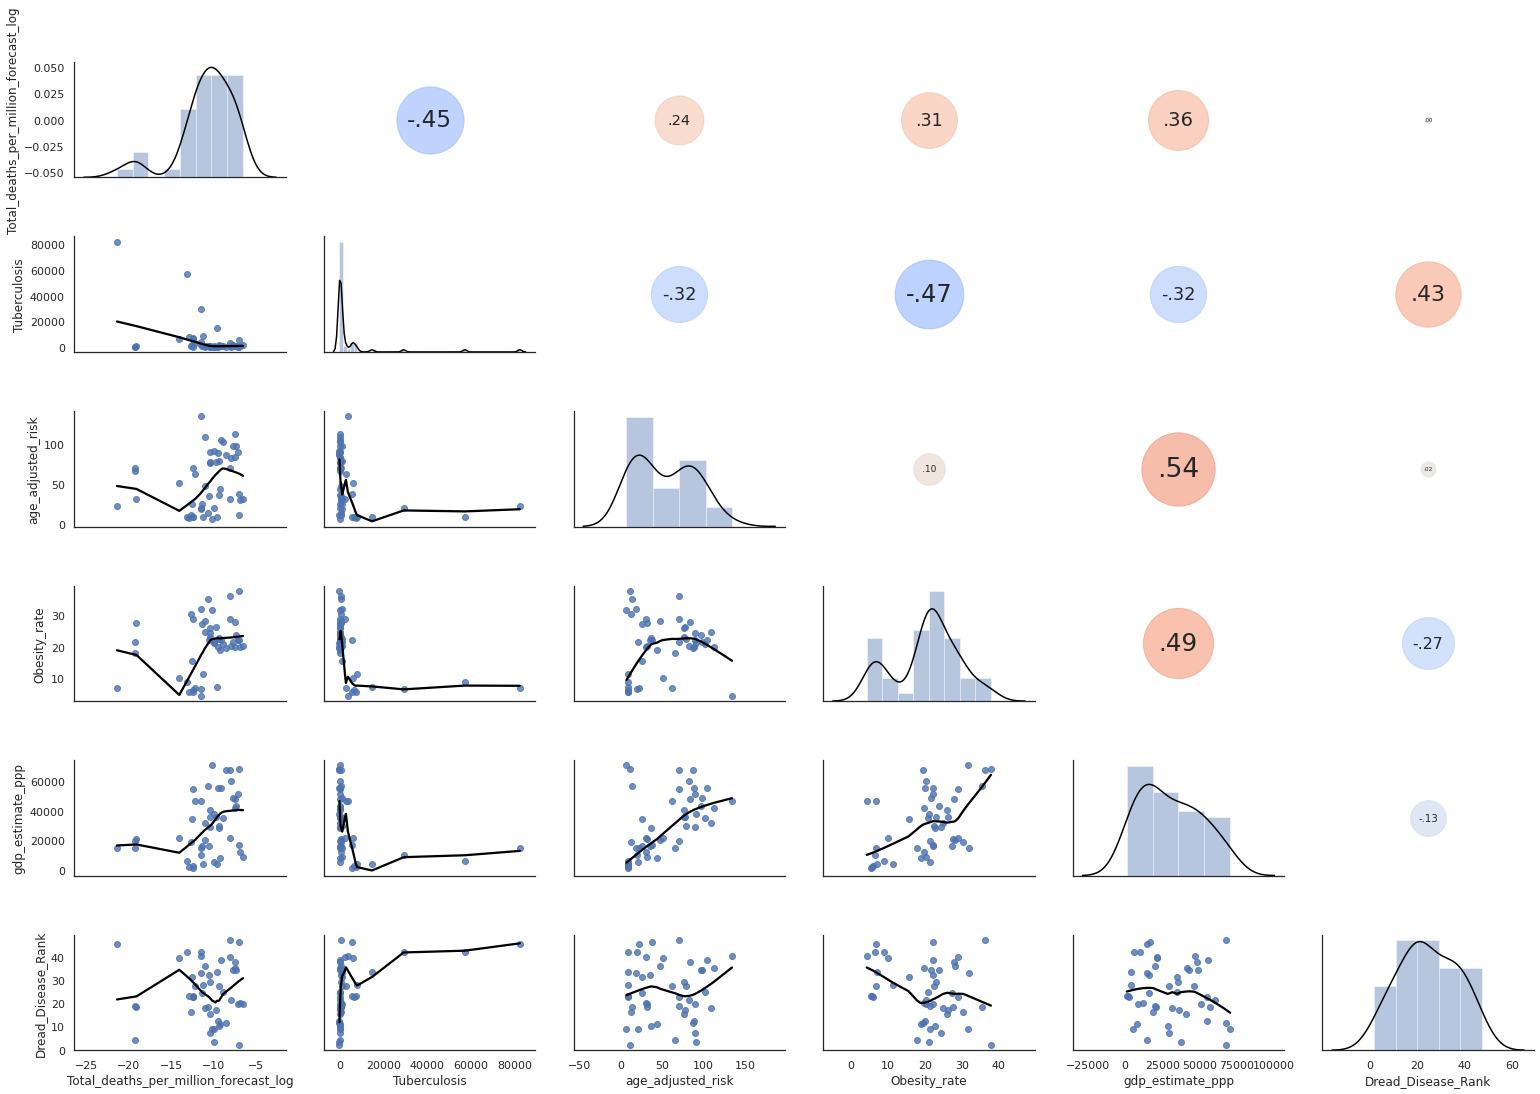

In [42]:
dataset = country_aggs_[['Total_deaths_per_million_forecast_log','Tuberculosis','age_adjusted_risk','Obesity_rate','gdp_estimate_ppp','Dread_Disease_Rank']]
sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

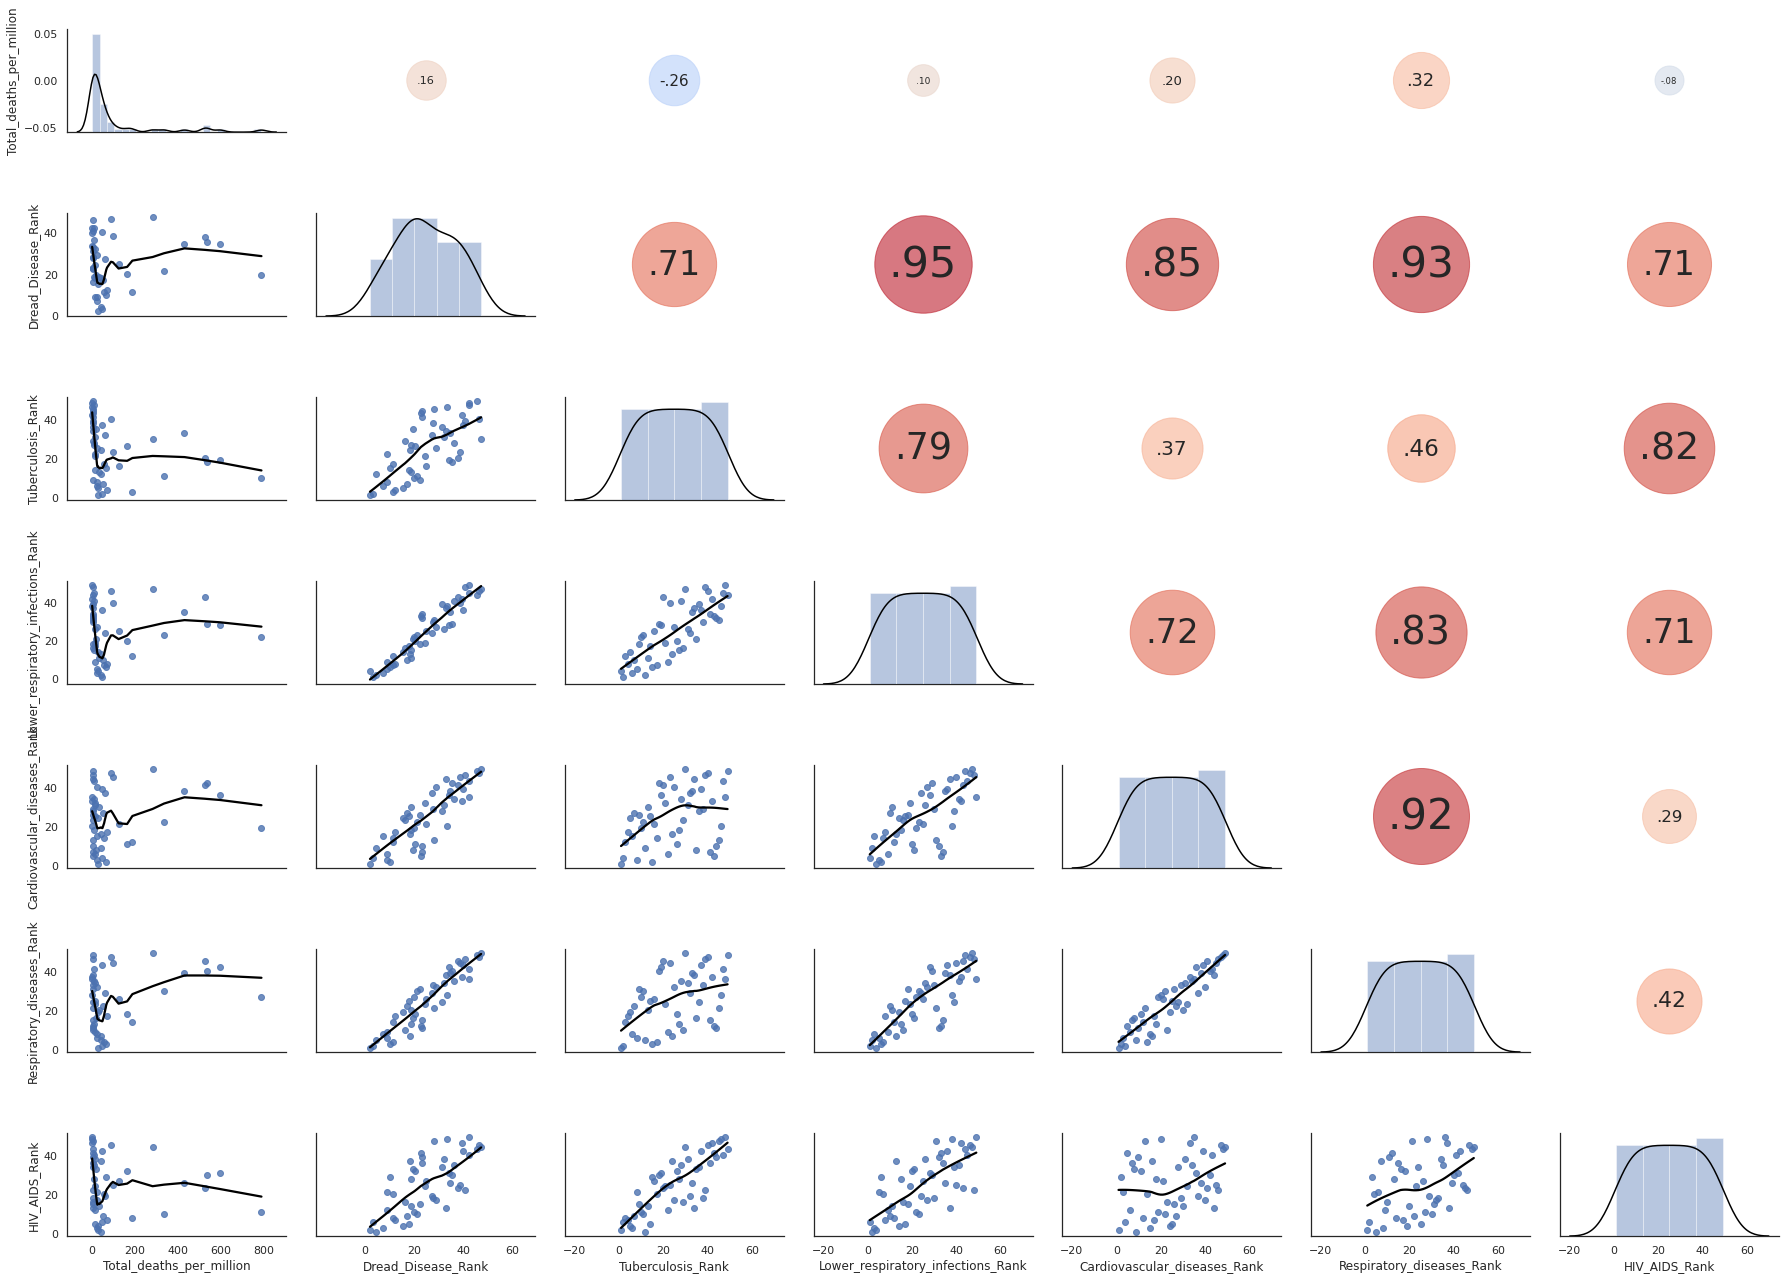

In [43]:
dataset = country_aggs_[['Total_deaths_per_million','Dread_Disease_Rank','Tuberculosis_Rank','Lower_respiratory_infections_Rank','Cardiovascular_diseases_Rank','Respiratory_diseases_Rank','HIV_AIDS_Rank']]
sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

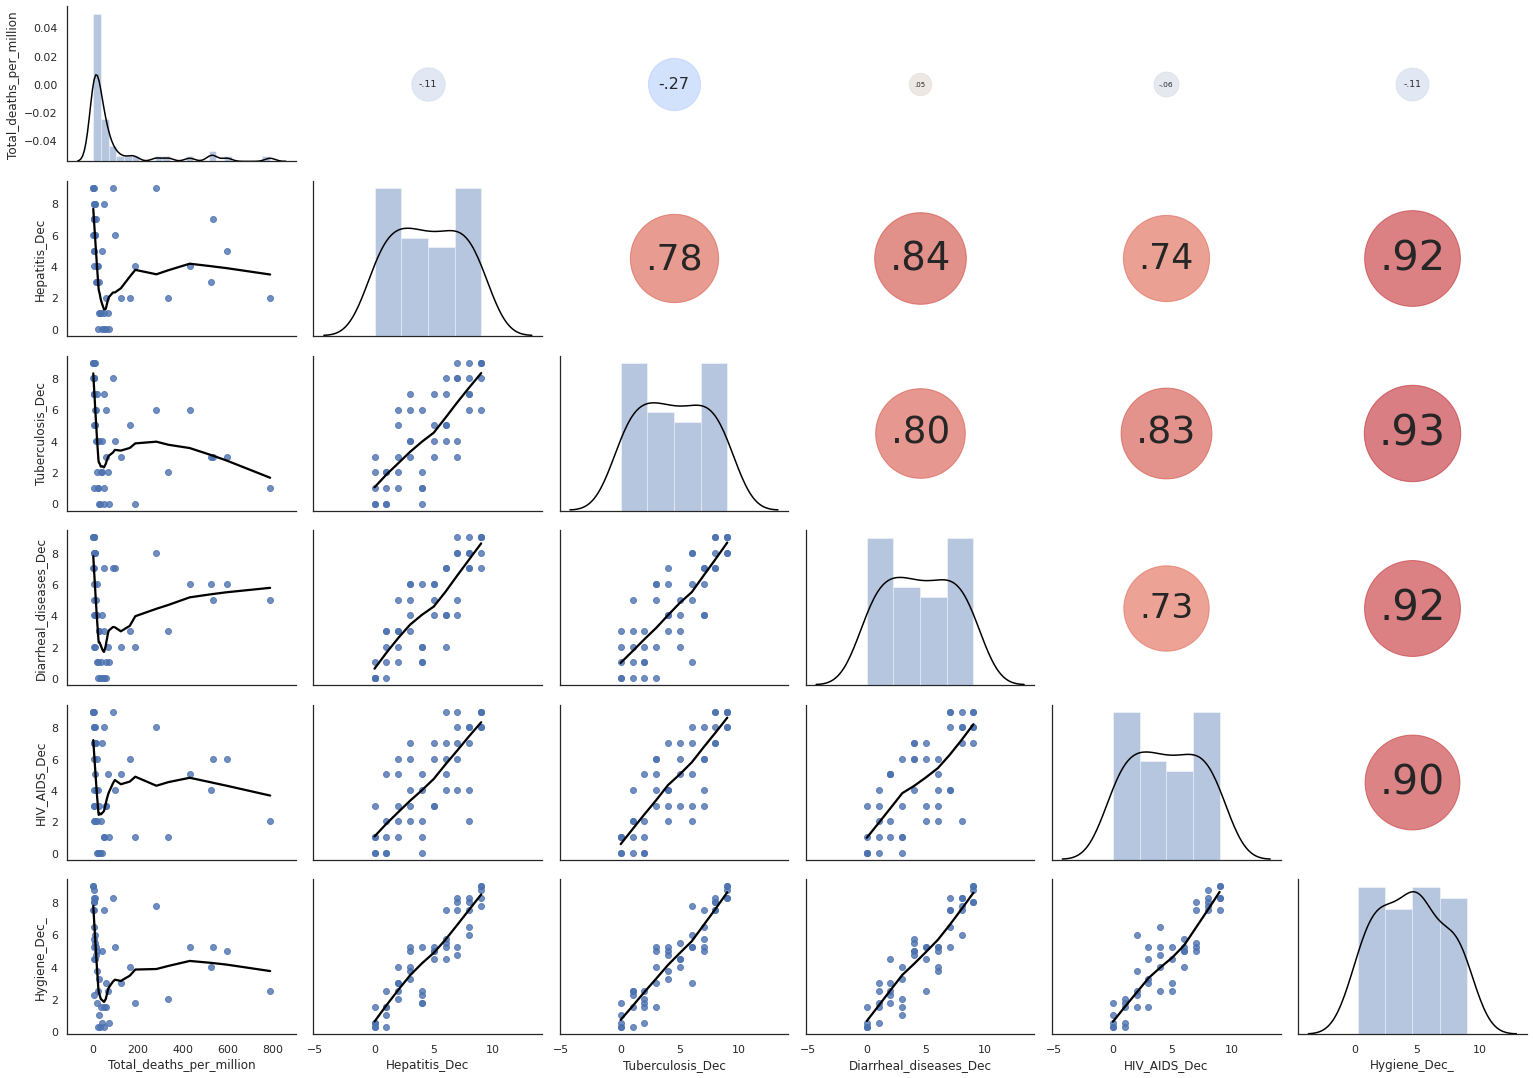

In [44]:
#dataset = country_aggs_[['Total_deaths_per_million','Hepatitis','Tuberculosis','Diarrheal_diseases','HIV_AIDS','Hygiene_Dec_']]
dataset = country_aggs_[['Total_deaths_per_million','Hepatitis_Dec','Tuberculosis_Dec','Diarrheal_diseases_Dec','HIV_AIDS_Dec','Hygiene_Dec_']]

sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

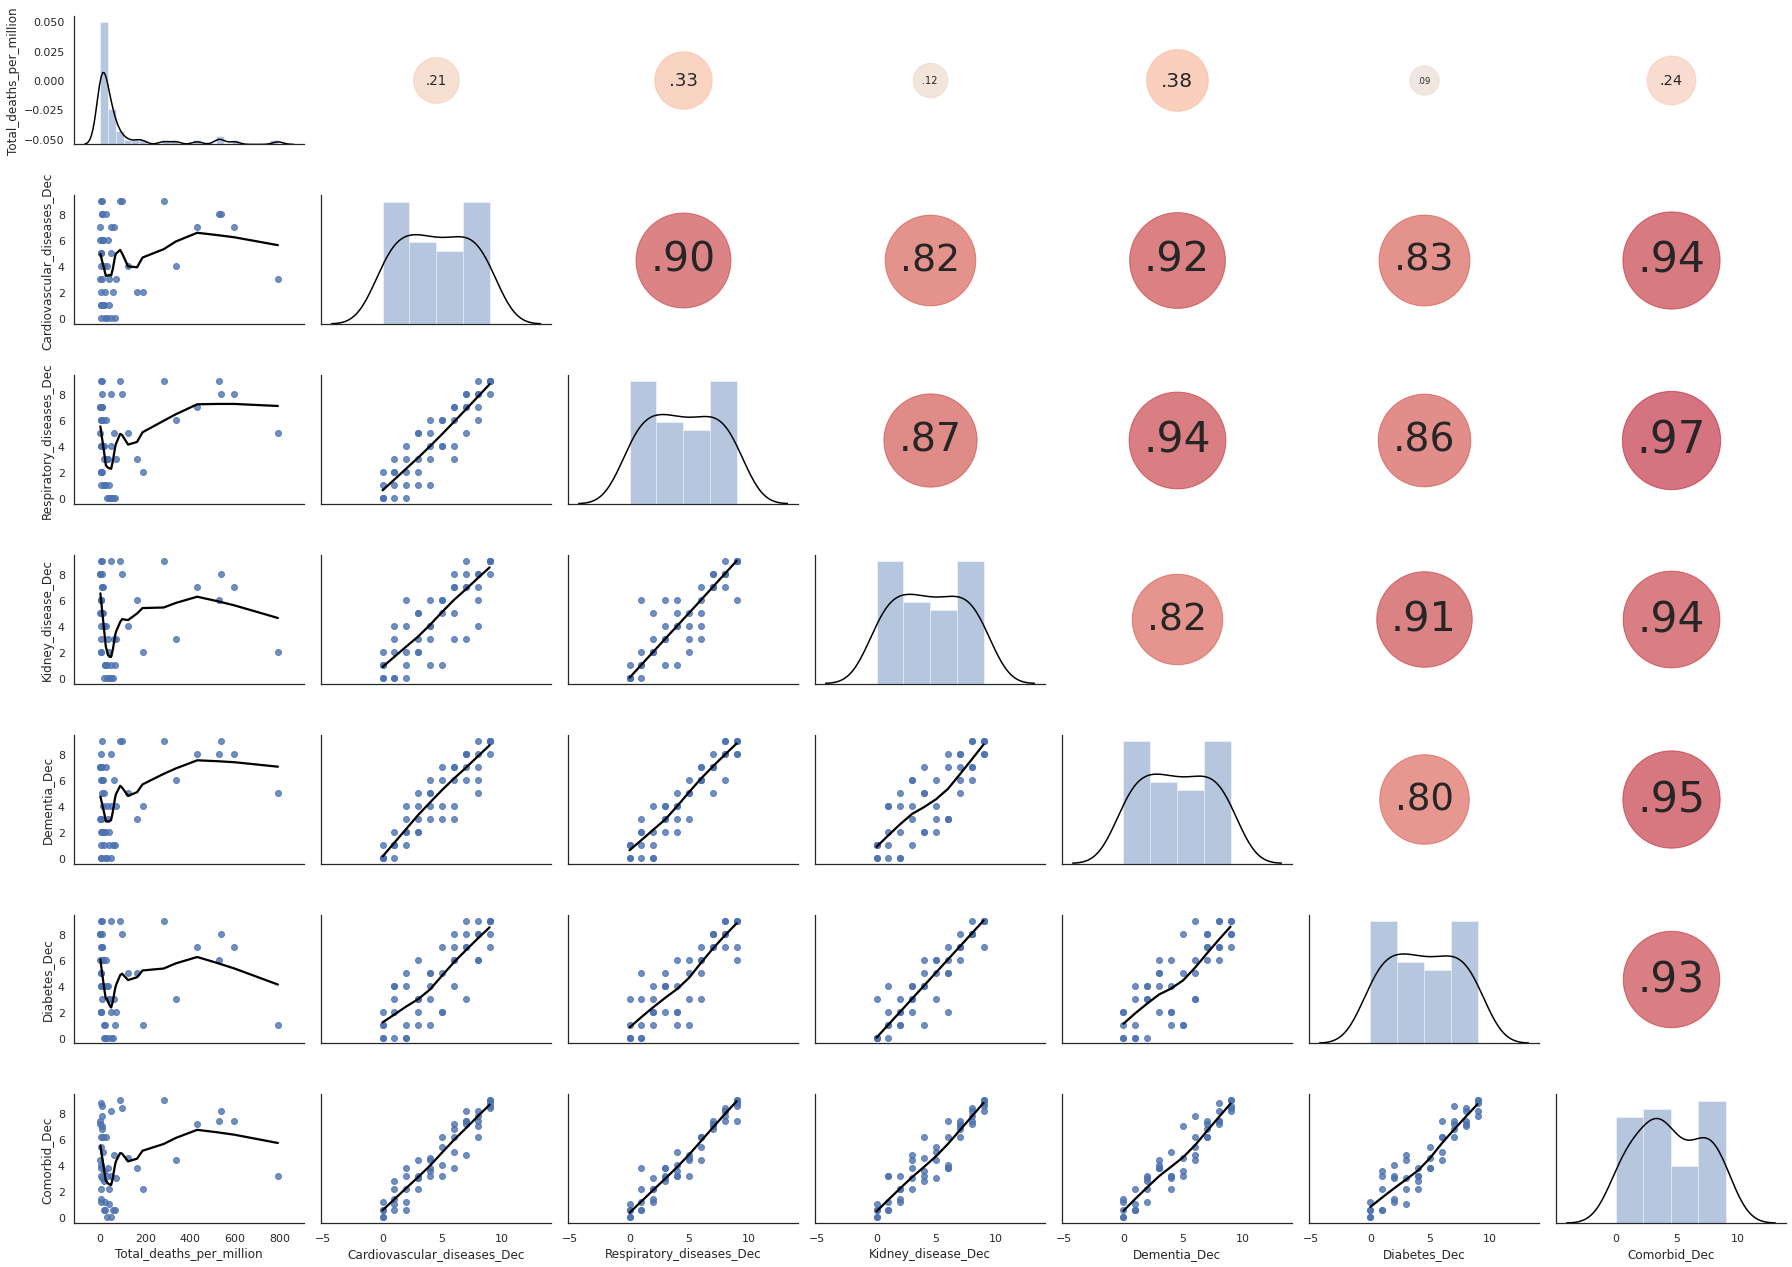

In [45]:
dataset = country_aggs_[['Total_deaths_per_million','Cardiovascular_diseases_Dec','Respiratory_diseases_Dec','Kidney_disease_Dec','Dementia_Dec','Diabetes_Dec','Comorbid_Dec']]
sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(dataset, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

Pure diseases model check:

In [46]:
from statsmodels.formula.api import ols
#model_custom = ols(formula = 'np.log(Total_deaths_per_million) ~  age_adjusted_risk + population_size + Density_overall * Obesity_rate : Median_Age  + np.power(UV_radiation,10) + gdp_estimate_ppp + np.power(Inequality_spatial_transformed,7) + np.power(StringencyIndex,7) + gov_response_fraction_DPM ', data=country_aggs_).fit()


#model_custom = ols(formula = '(Total_deaths_per_million) ~  StringencyIndex', data=country_aggs_).fit()
model_custom = ols(formula = 'np.log(Total_deaths_per_million) ~  Obesity_rate:Hygiene_Dec_ + Comorbid_Dec + age_adjusted_risk', data=country_aggs_).fit()
#model_custom = ols(formula = 'np.log(Total_deaths_per_million) ~  Tuberculosis_Dec + Comorbid_Dec + age_adjusted_risk', data=country_aggs_).fit()
model_custom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     np.log(Total_deaths_per_million)   R-squared:                       0.521
Model:                                          OLS   Adj. R-squared:                  0.489
Method:                               Least Squares   F-statistic:                     16.31
Date:                              Sun, 31 May 2020   Prob (F-statistic):           2.57e-07
Time:                                      19:49:02   Log-Likelihood:                -79.856
No. Observations:                                49   AIC:                             167.7
Df Residuals:                                    45   BIC:                             175.3
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.9413      0.468      2.010      0.050      -0.002       1.885
Obesity_rate:Hygiene_Dec_     0.0163      0.004      3.846      0.000       0.008       0.025
Comorbid_Dec                 -0.2771      0.090     -3.079      0.004      -0.458      -0.096
age_adjusted_risk             0.0411      0.006      6.898      0.000       0.029       0.053
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.324
Skew:                           0.012   Prob(JB):                        0.850
Kurtosis:                       2.602   Cond. No.                         278.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

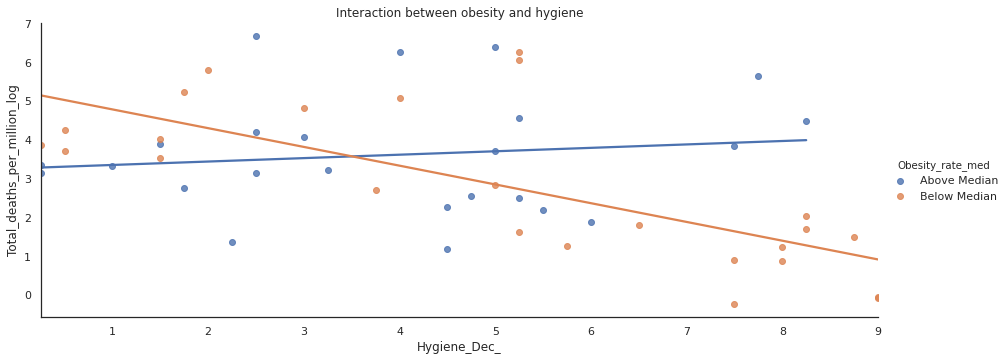

In [47]:
country_aggs_['Obesity_rate_med'] = country_aggs_.Obesity_rate > country_aggs_.Obesity_rate.median()
country_aggs_['Obesity_rate_med'] = np.where(country_aggs_.Obesity_rate_med == False, "Below Median", "Above Median")
sns.lmplot(x='Hygiene_Dec_', y='Total_deaths_per_million_log', hue='Obesity_rate_med', data=country_aggs_, ci=None, size=5, aspect=2.5)
plt.title('Interaction between obesity and hygiene');

The above interaction is interprested as follows:

When Obesity_rate is below the median, then there is a strong inverse relationship between response variable and hygiene proxy. However, when Obesity_rate is above the median, then there exists a weak positive relationship response and hygiene.

# Start linear modeling
# Feature engineering
Helper function for fitting linear regression:

In [48]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,np.log(Y))
    RSS = mean_squared_error(np.log(Y),model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,np.log(Y))
    return RSS, R_squared
    

Transform some variables after inspection:

In [49]:
#inspection...
#time goes by...
# more time goes by...
#...some time later:
#country_aggs_['StringencyIndex'] = np.log(country_aggs_['StringencyIndex'])
#country_aggs_['Obesity_rate'] = np.sin(country_aggs_['Obesity_rate'])
#country_aggs_['UV_radiation'] = np.log(country_aggs_['UV_radiation'])

#country_aggs_['Cig_Consumption_Rank'] = country_aggs_['Cig_Consumption_Rank'].astype(float)
#country_aggs_['Cigarette_consumption'] = country_aggs_['Cigarette_consumption'].str.replace(',', '').astype(float)

Create X and y and then loop over forward variable selection and record fit results:

In [50]:
#Importing tqdm for the progress bar
from tqdm import tqdm_notebook
from tqdm.notebook import trange
#Initialization variables
X = country_aggs_[['Density_overall','Obesity_rate','gdp_estimate_ppp','Median_Age','age_adjusted_risk','Inequality_spatial_transformed','Tuberculosis','Tuberculosis_Rank','Dread_Disease_Rank']]
#X = country_aggs_[['Tuberculosis_log','age_adjusted_risk','Obesity_rate','gdp_estimate_ppp']]
#Y = country_aggs_[['CaseFatalityRate']]
Y = country_aggs_[['Total_deaths_per_million_forecast']]
k = 10
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in trange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

Observe output of loop, rank by RSS and R_Squared:

In [51]:
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
#display(df_min.head(20))
display(df_max.head(20))

,numb_features,RSS,R_squared,features
6,1,418.650228,0.203894,"(Tuberculosis,)"
27,2,391.082277,0.256317,"(gdp_estimate_ppp, Tuberculosis)"
107,3,366.437142,0.303183,"(gdp_estimate_ppp, Tuberculosis, Dread_Disease..."
221,4,345.335270,0.343310,"(gdp_estimate_ppp, Median_Age, age_adjusted_ri..."
364,5,332.199839,0.368288,"(gdp_estimate_ppp, Median_Age, age_adjusted_ri..."
462,6,312.007006,0.406687,"(gdp_estimate_ppp, Median_Age, Inequality_spat..."
500,7,297.283473,0.434685,"(gdp_estimate_ppp, Median_Age, age_adjusted_ri..."
508,8,294.318590,0.440323,"(Density_overall, gdp_estimate_ppp, Median_Age..."
510,9,294.318515,0.440324,"(Density_overall, Obesity_rate, gdp_estimate_p..."


Single variable prediction for importance:

In [52]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df[df['numb_features'] == 1].sort_values('R_squared', ascending=False).head(11)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
6,1,418.650228,0.203894,"(Tuberculosis,)",418.650228,0.203894
2,1,457.655754,0.129721,"(gdp_estimate_ppp,)",418.650228,0.203894
1,1,474.944201,0.096846,"(Obesity_rate,)",418.650228,0.203894
4,1,495.510308,0.057737,"(age_adjusted_risk,)",418.650228,0.203894
7,1,498.253794,0.052520,"(Tuberculosis_Rank,)",418.650228,0.203894
3,1,511.811513,0.026739,"(Median_Age,)",418.650228,0.203894
5,1,524.712308,0.002206,"(Inequality_spatial_transformed,)",418.650228,0.203894
0,1,525.638849,0.000445,"(Density_overall,)",418.650228,0.203894
8,1,525.862218,0.000020,"(Dread_Disease_Rank,)",418.650228,0.203894


Plot best subset:

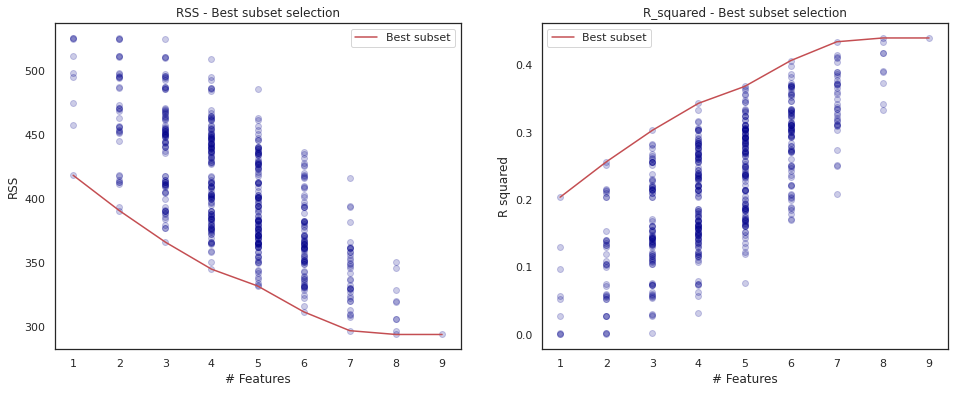

In [53]:

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

# Build custom model and calculate coefficients:

In [54]:
country_aggs_ = country_aggs_.rename(columns={'gov_response_at_0.1_deaths_per_million': 'gov_response_fraction_DPM'})

In [55]:
from statsmodels.formula.api import ols
#model_custom = ols(formula = 'np.log(Total_deaths_per_million) ~  age_adjusted_risk + population_size + Density_overall * Obesity_rate : Median_Age  + np.power(UV_radiation,10) + gdp_estimate_ppp + np.power(Inequality_spatial_transformed,7) + np.power(StringencyIndex,7) + gov_response_fraction_DPM ', data=country_aggs_).fit()
#model_custom = ols(formula = 'np.log(Total_deaths_per_million_forecast) ~  Tuberculosis + age_adjusted_risk + Obesity_rate + gdp_estimate_ppp', data=country_aggs_).fit()
model_custom = ols(formula = 'np.log(Total_deaths_per_million) ~ age_adjusted_risk + Tuberculosis_Dec + Comorbid_Dec ', data=country_aggs_).fit()
model_custom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     np.log(Total_deaths_per_million)   R-squared:                       0.470
Model:                                          OLS   Adj. R-squared:                  0.435
Method:                               Least Squares   F-statistic:                     13.33
Date:                              Sun, 31 May 2020   Prob (F-statistic):           2.34e-06
Time:                                      19:49:09   Log-Likelihood:                -82.313
No. Observations:                                49   AIC:                             172.6
Df Residuals:                                    45   BIC:                             180.2
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.2318      0.640      5.047      0.000       1.942       4.521
age_adjusted_risk     0.0138      0.008      1.701      0.096      -0.003       0.030
Tuberculosis_Dec     -0.3247      0.108     -3.014      0.004      -0.542      -0.108
Comorbid_Dec          0.1585      0.102      1.554      0.127      -0.047       0.364
==============================================================================
Omnibus:                        0.492   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.517
Skew:                          -0.221   Prob(JB):                        0.772
Kurtosis:                       2.761   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Assess fit:

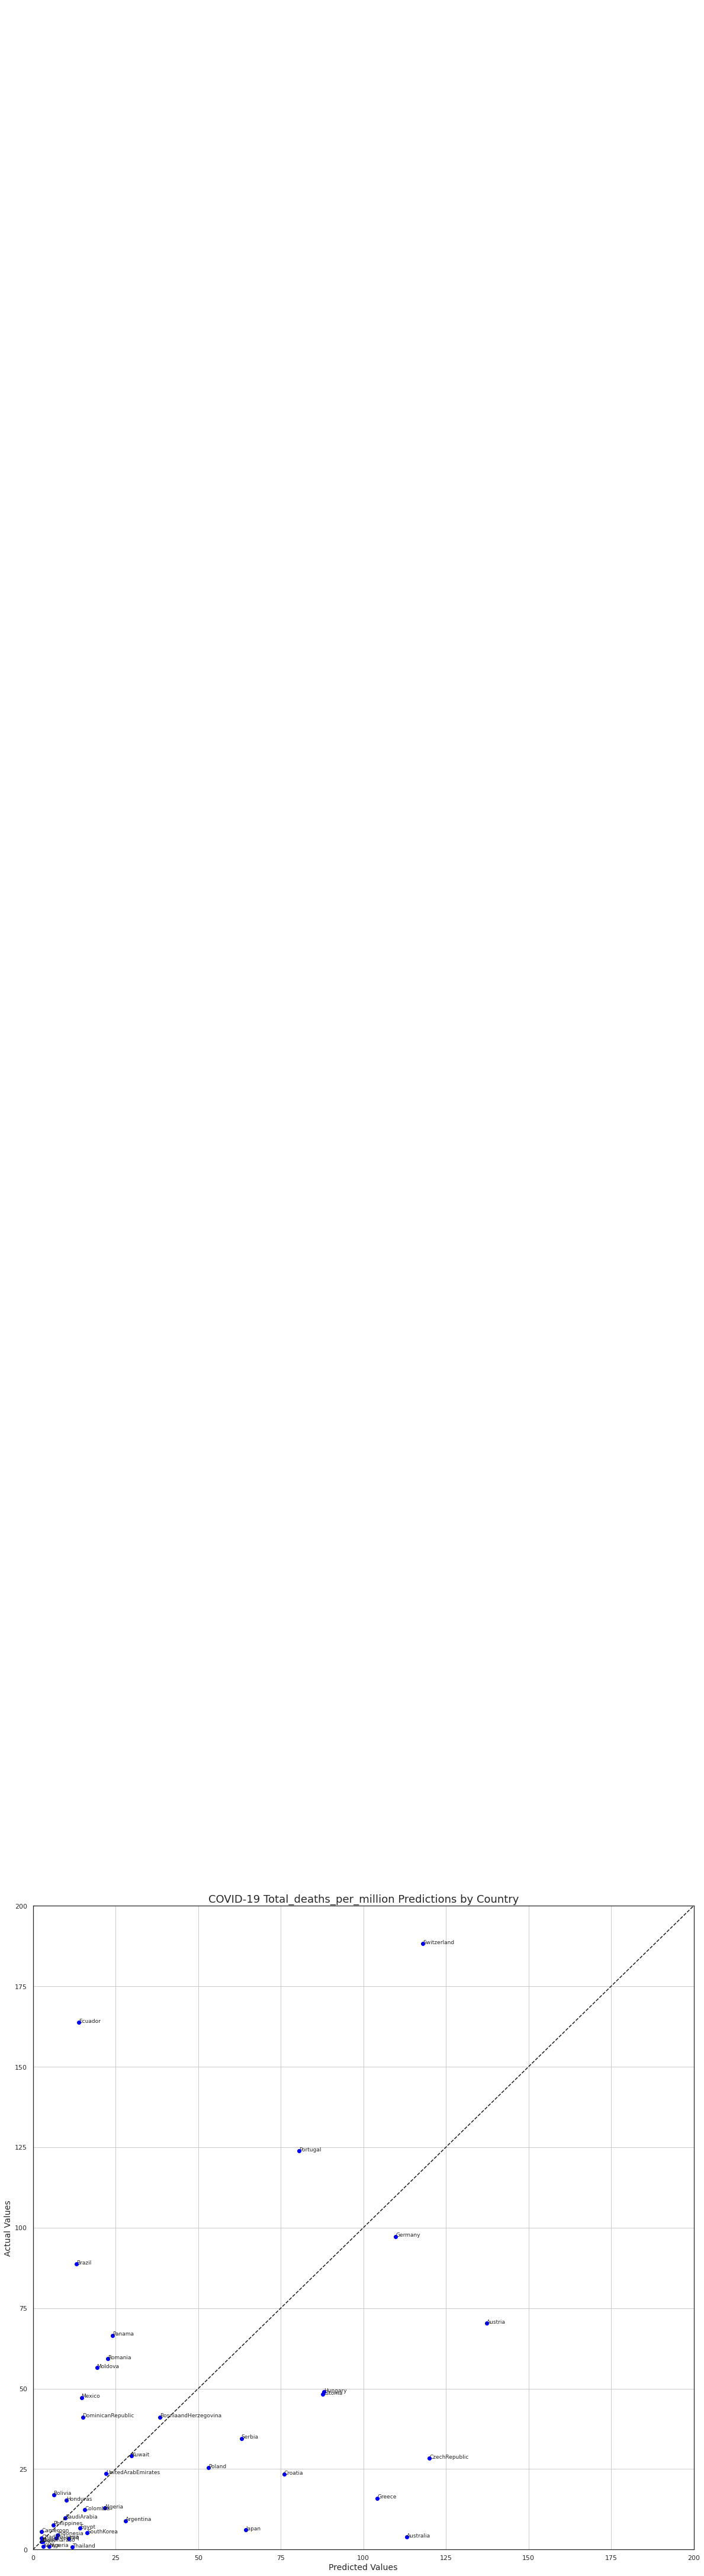

In [56]:
x_ = np.exp(model_custom.fittedvalues)
y_ = country_aggs_['Total_deaths_per_million']
countries = country_aggs_['Country']

fig, ax = plt.subplots(figsize=(20,20))

ax.set_xlabel('Predicted Values', fontsize=14)
ax.set_ylabel('Actual Values', fontsize=14)
ax.set_title('COVID-19 Total_deaths_per_million Predictions by Country', fontsize=18)

plt.scatter(x_,y_,color = "blue")
for label, xx, yy in zip(countries, x_, y_):
    plt.annotate(label, xy = (xx, yy),fontsize = 9)
plt.grid(True)

plt.ylim(0,200)
plt.xlim(0,200)
plt.plot([0, 200], [0, 200], '--k') 
plt.show()

Zoom in a bit:

In [57]:
country_aggs_['fittedvalues'] = np.exp(model_custom.fittedvalues)

In [58]:
country_aggs__ = country_aggs_[country_aggs_['Total_deaths_per_million'] <= 200]
country_aggs__.head(2)

,Country,Total_deaths_per_million,TotalConfirmedCases,TotalFatalities,Obesity_rate,Median_Age,gdp_estimate_ppp,age_adjusted_risk,Inequality_spatial_transformed,StringencyIndex,gov_response_fraction_DPM,days_since_outbreak,area,population_size,total_deaths_forecast,peak_deaths_already_occurred_indicator,CaseFatalityRate,intercept,matches,Year,Meningitis,Lower_respiratory_infections,Protein_energy_malnutrition,Cardiovascular_diseases,Dementia,Kidney_disease,Respiratory_diseases,Liver_diseases,Digestive_diseases,Hepatitis,Cancers,Parkinson_disease,Fire,Drowning,Homicide,HIV_AIDS,Drug_use_disorders,Tuberculosis,Road_injuries,Maternal_disorders,Neonatal_disorders,Alcohol_use_disorders,Diarrheal_diseases,Hot_Cold_exposure,Nutritional_deficiencies,Suicide,Diabetes,Poisonings,Density_overall,PopulationFatality,Total_deaths_per_million_forecast,Tuberculosis_log,Total_deaths_per_million_forecast_log,Total_deaths_per_million_log,Tuberculosis_Rank,Lower_respiratory_infections_Rank,Cardiovascular_diseases_Rank,Respiratory_diseases_Rank,HIV_AIDS_Rank,Hepatitis_Rank,Diarrheal_diseases_Rank,Hygiene_Rank_,Dread_Disease_Rank,Lower_respiratory_infections_Dec,Total_deaths_per_million_Dec,Tuberculosis_Dec,HIV_AIDS_Dec,Hepatitis_Dec,Diarrheal_diseases_Dec,Cardiovascular_diseases_Dec,Respiratory_diseases_Dec,Kidney_disease_Dec,Dementia_Dec,Diabetes_Dec,Hygiene_Dec_,Comorbid_Dec,Dread_Disease_Rank_,Obesity_rate_med,fittedvalues
0,Algeria,12.953,7542,568,27.4,28.9,16090.69,25.589402,18.046072,84.54,37.7,85.0,2.317000e+12,43851043.0,537.220767,1.0,0.075312,1,Algeria,2017,379.614524,4723.762257,80.517066,79389.07324,8175.242117,4577.022553,5508.419832,2935.124513,4800.227615,312.704332,21656.08309,1139.958076,735.957263,509.292514,438.667163,326.660742,1010.678862,417.069297,6905.410229,630.191116,6511.279864,130.332484,377.244709,50.093911,97.704089,1698.665146,5201.535330,366.645603,0.195685,0.000013,12.251037,6.033252,-11.30990,2.561327,21.0,19.0,32.0,23.0,24.0,36.0,21.0,25.5,24.50,3,3,4,4,7,4,6,4,5,4,6,4.75,5.0,98.0,Above Median,21.700612
1,Argentina,8.917,9270,403,28.3,32.4,19970.52,47.082577,12.998710,100.00,100.0,78.0,2.780950e+12,45195777.0,720.780001,1.0,0.043474,1,Argentina,2017,494.948379,31058.142250,983.607619,105776.74050,18616.816490,10834.300190,18992.483860,7346.319944,14905.837910,178.405093,74065.89666,2917.513863,756.370034,709.834602,2733.485868,1719.217843,797.912049,679.348497,6457.318523,378.840519,3600.109017,857.090286,651.446992,101.200180,1075.354199,5024.770844,9345.109432,357.743936,0.191265,0.000009,15.947950,6.521134,-11.04618,2.187960,28.0,41.0,34.0,35.0,35.0,31.0,24.0,29.5,36.25,8,3,5,7,6,4,6,7,7,7,7,5.50,6.8,145.0,Above Median,28.036351


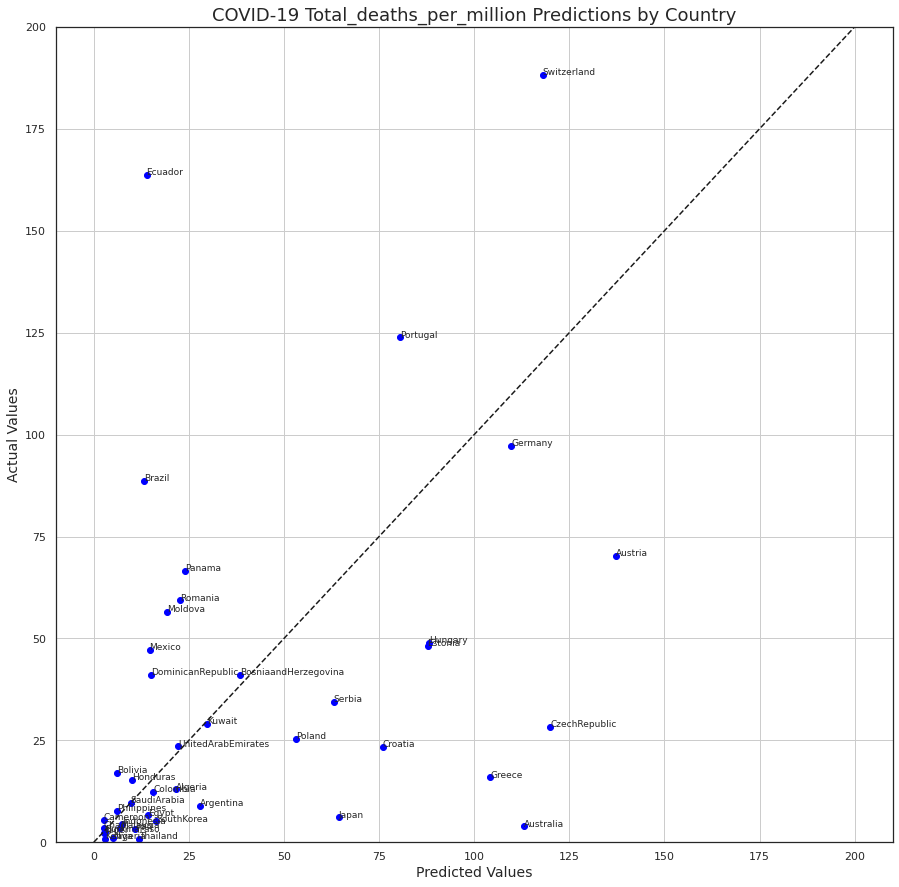

In [59]:

x_ = country_aggs__['fittedvalues']
y_ = country_aggs__['Total_deaths_per_million']
countries = country_aggs__['Country']

fig, ax = plt.subplots(figsize=(15,15))

ax.set_xlabel('Predicted Values', fontsize=14)
ax.set_ylabel('Actual Values', fontsize=14)
ax.set_title('COVID-19 Total_deaths_per_million Predictions by Country', fontsize=18)

plt.scatter(x_,y_,color = "blue")
for label, xx, yy in zip(countries, x_, y_):
    plt.annotate(label, xy = (xx, yy),fontsize = 9)
plt.grid(True)
plt.ylim(0,200)
plt.plot([0, 200], [0, 200], '--k') 
plt.show()

Full table of rates and fitted rates:

In [60]:
pd.set_option('display.max_rows', None)
country_aggs_[['Country','Total_deaths_per_million','Total_deaths_per_million_forecast','fittedvalues','TotalConfirmedCases','TotalFatalities']]

,Country,Total_deaths_per_million,Total_deaths_per_million_forecast,fittedvalues,TotalConfirmedCases,TotalFatalities
0,Algeria,12.953,12.251037,21.700612,7542,568
1,Argentina,8.917,15.947950,28.036351,9270,403
2,Australia,3.922,4.121422,113.085960,7079,100
3,Austria,70.283,73.146541,137.241045,16275,633
4,Belgium,789.500,813.546929,104.212738,55983,9150
5,Bolivia,17.048,1444.043424,6.238378,4919,199
6,BosniaandHerzegovina,41.148,0.004573,38.393119,2334,135
7,Brazil,88.723,881.495660,13.111414,291579,18859
8,BurkinaFaso,2.488,2.567053,2.994273,809,52
9,Cameroon,5.500,12.716581,2.573180,3733,146


# Hold out model:

In [61]:
from sklearn.model_selection import train_test_split
X = country_aggs_[['intercept','age_adjusted_risk','Density_overall','Obesity_rate','gdp_estimate_ppp','Median_Age','Inequality_spatial_transformed','StringencyIndex','gov_response_fraction_DPM','Tuberculosis']]
y = np.log(country_aggs_[['Total_deaths_per_million_forecast']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_test

,intercept,age_adjusted_risk,Density_overall,Obesity_rate,gdp_estimate_ppp,Median_Age,Inequality_spatial_transformed,StringencyIndex,gov_response_fraction_DPM,Tuberculosis
46,1,7.005291,0.264513,31.7,70441.547,38.4,6.552444,91.54,46.96,79.874580
9,1,9.339196,0.230949,11.4,4099.367,18.5,5.103787,76.32,62.43,8077.382887
8,1,8.273140,0.241416,5.6,2181.430,17.9,2.196681,92.72,77.64,7391.083849
35,1,36.718643,0.231722,22.7,28456.005,30.1,5.474657,83.60,9.92,197.663722
26,1,134.029995,0.301897,4.3,46827.354,48.6,5.185649,53.30,44.71,3870.258569


In [62]:
model_holdout = sm.OLS(y_train,X_train).fit()
model_holdout.summary()
# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model_holdout.predict(X_test)
y_hat_train = model_holdout.predict(X_train)
model_holdout.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Total_deaths_per_million_forecast   R-squared:                       0.415
Model:                                           OLS   Adj. R-squared:                  0.260
Method:                                Least Squares   F-statistic:                     2.679
Date:                               Sun, 31 May 2020   Prob (F-statistic):             0.0181
Time:                                       19:49:11   Log-Likelihood:                -104.90
No. Observations:                                 44   AIC:                             229.8
Df Residuals:                                     34   BIC:                             247.6
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept                         11.6135      6.874      1.689      0.100      -2.357      25.584
age_adjusted_risk                  0.0656      0.041      1.610      0.117      -0.017       0.148
Density_overall                   -6.5800     17.982     -0.366      0.717     -43.124      29.964
Obesity_rate                       0.0430      0.083      0.520      0.606      -0.125       0.211
gdp_estimate_ppp                5.824e-05   4.17e-05      1.397      0.171   -2.65e-05       0.000
Median_Age                        -0.3247      0.148     -2.196      0.035      -0.625      -0.024
Inequality_spatial_transformed    -0.0932      0.067     -1.391      0.173      -0.229       0.043
StringencyIndex                    0.0110      0.074      0.148      0.883      -0.140       0.162
gov_response_fraction_DPM         -0.0263      0.026     -1.023      0.313      -0.078       0.026
Tuberculosis                   -8.132e-05   3.92e-05     -2.074      0.046      -0.000   -1.65e-06
==============================================================================
Omnibus:                       14.234   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.762
Skew:                          -1.105   Prob(JB):                     0.000229
Kurtosis:                       5.063   Cond. No.                     1.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Do lockdown regulations help much?

The Stringency Index in the model above stems from the work done on government response to the pandemic by the University of Oxford:
https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker

The stringency index used in the above model, in laymans terms, reflects to what level the government intervened to enforce social distancing amongst people, across borders, and more.

Acording to the model run above, the StringencyIndex has a p-value of 0.7 odd, which is far from being significant in any way in explaining the variance in the response variable (that is the total deaths per million forecast).

In the below plot, the higher the index, the more intensive the regulations:

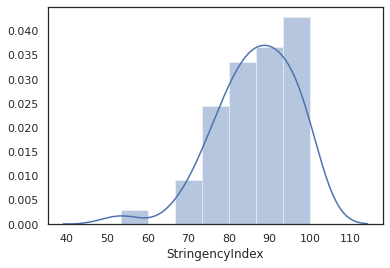

In [63]:
sns.distplot(country_aggs_['StringencyIndex'])
plt.show()

In [64]:
country_aggs[['Country','StringencyIndex']].head(10)

,Country,StringencyIndex
1,Algeria,84.54
3,Argentina,100.00
5,Australia,71.44
6,Austria,84.79
9,Belgium,83.60
10,Bolivia,97.35
11,BosniaandHerzegovina,91.40
12,Brazil,75.15
14,BurkinaFaso,92.72
15,Cameroon,76.32


Compare test vs train errors. Ideally should be close to each other:

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# See our Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, np.exp(y_hat_test))
test_rmse = np.sqrt(test_mse)
# train rmse
train_mse = mean_squared_error(y_train, np.exp(y_hat_train))
train_rmse = np.sqrt(train_mse)
# See our Mean Absolute Error
test_mae = mean_absolute_error(y_test, np.exp(y_hat_test))
train_mae = mean_absolute_error(y_train, np.exp(y_hat_train))
print(f"_________________________________")
print(f"Mean Absolute Error")
print(f"---------------------------------")
print(f"the test MAE is: {test_mae}")
print(f"the train MAE is: {train_mae}")
print(f"_________________________________")
print(f"Root Mean Square Error (RMSE)")
print(f"---------------------------------")
print(f"the test_rmse is: {test_rmse}")
print(f"the train_rmse is: {train_rmse}")
print(f"_________________________________")

_________________________________
Mean Absolute Error
---------------------------------
the test MAE is: 72.63715421977687
the train MAE is: 105.14003288184453
_________________________________
Root Mean Square Error (RMSE)
---------------------------------
the test_rmse is: 110.970874633178
the train_rmse is: 218.33164318752102
_________________________________


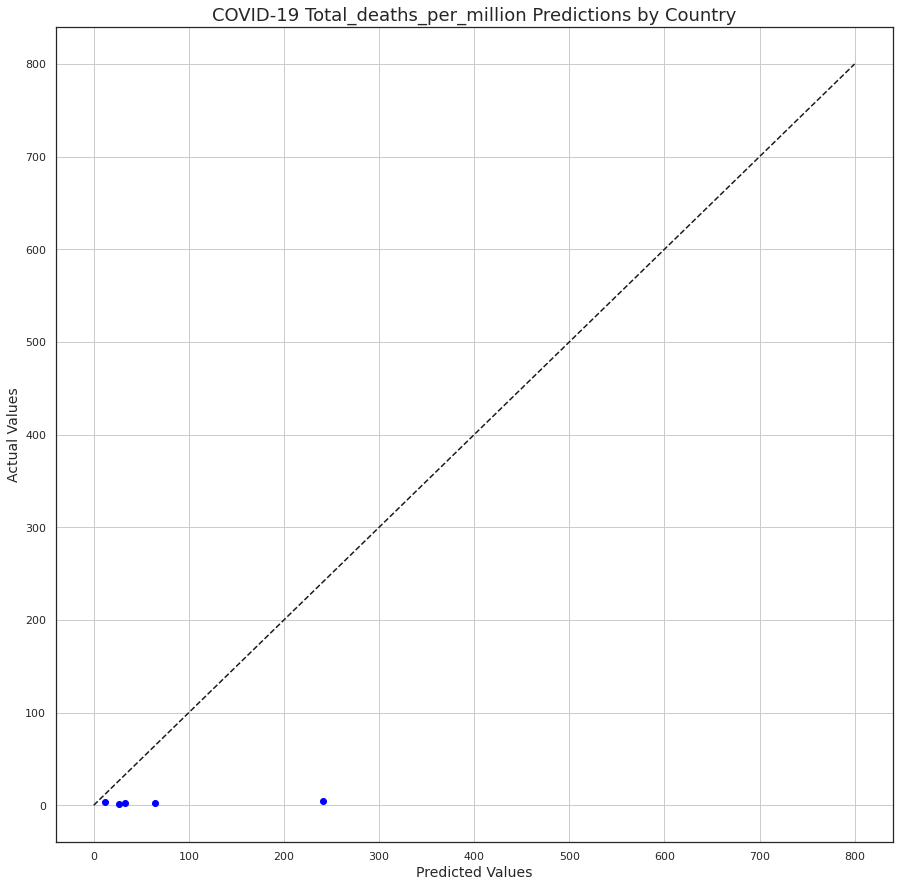

In [66]:
x_ = np.exp(y_hat_test)
y_ = y_test
#countries = country_aggs__['Country']

fig, ax = plt.subplots(figsize=(15,15))

ax.set_xlabel('Predicted Values', fontsize=14)
ax.set_ylabel('Actual Values', fontsize=14)
ax.set_title('COVID-19 Total_deaths_per_million Predictions by Country', fontsize=18)

plt.scatter(x_,y_,color = "blue")
#for label, xx, yy in zip(countries, x_, y_):
#    plt.annotate(label, xy = (xx, yy),fontsize = 9)
plt.grid(True)

plt.plot([0, 800], [0, 800], '--k') 
plt.show()

In [67]:
country_aggs_['fittedvalues_holdout'] = np.exp(model_holdout.predict(X))
pd.set_option('display.max_rows', None)
country_aggs_[['Country','Total_deaths_per_million','Total_deaths_per_million_forecast','fittedvalues','fittedvalues_holdout','TotalConfirmedCases','TotalFatalities']]

,Country,Total_deaths_per_million,Total_deaths_per_million_forecast,fittedvalues,fittedvalues_holdout,TotalConfirmedCases,TotalFatalities
0,Algeria,12.953,12.251037,21.700612,19.222378,7542,568
1,Argentina,8.917,15.947950,28.036351,12.243141,9270,403
2,Australia,3.922,4.121422,113.085960,9.001782,7079,100
3,Austria,70.283,73.146541,137.241045,90.631804,16275,633
4,Belgium,789.500,813.546929,104.212738,405.047450,55983,9150
5,Bolivia,17.048,1444.043424,6.238378,25.286965,4919,199
6,BosniaandHerzegovina,41.148,0.004573,38.393119,1.528949,2334,135
7,Brazil,88.723,881.495660,13.111414,5.075313,291579,18859
8,BurkinaFaso,2.488,2.567053,2.994273,26.954048,809,52
9,Cameroon,5.500,12.716581,2.573180,32.862419,3733,146
